# Project Introduction: Integrating MA Crossover and MACD for Stock Analysis

## Objective
The objective of this project is to develop a reliable stock screening tool that identifies potential buy and sell signals using two popular technical indicators: the Moving Average (MA) Crossover and the Moving Average Convergence Divergence (MACD). By combining these indicators, we aim to enhance the accuracy of our signals, leveraging the strengths of both trend-following and momentum analysis.

## Background
Technical analysis involves using historical price and volume data to forecast future price movements. Among the myriad of technical indicators available, MA Crossover and MACD are two widely respected tools that traders use to assess market conditions.

## Why MA Crossover and MACD?

### Moving Average (MA) Crossover
- **Purpose:** The MA Crossover is used to identify potential trend reversals by examining the crossing points of different moving averages.
- **Components:**
  - **Short-Term MA:** A moving average calculated over a shorter period (e.g., 20-day MA).
  - **Long-Term MA:** A moving average calculated over a longer period (e.g., 100-day MA).
- **Potential Trend Reversals:**
  - **Potential Bullish Trend Reversal:** Occurs when the short-term MA crosses above the long-term MA, indicating a potential buy signal.
  - **Potential Bearish Trend Reversal:** Occurs when the short-term MA crosses below the long-term MA, indicating a potential sell signal.

### Moving Average Convergence Divergence (MACD)
- **Purpose:** The MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price.
- **Components:**
  - **MACD Line:** The difference between the 12-day EMA and the 26-day EMA.
  - **Signal Line:** The 9-day EMA of the MACD line.
  - **Histogram:** The difference between the MACD line and the Signal line.
- **Potential Trend Reversals:**
  - **Potential Bullish Trend Reversal:** When the MACD line crosses above the Signal line, indicating upward momentum.
  - **Potential Bearish Trend Reversal:** When the MACD line crosses below the Signal line, indicating downward momentum.

## Combining MA Crossover and MACD
Using these indicators together can help confirm signals and reduce false positives:
- **Enhanced Accuracy:** While the MA Crossover helps identify potential trend changes, MACD provides context by showing the momentum of the price movement during these changes.
- **Filter for False Signals:** The MA Crossover can sometimes give premature signals. By requiring confirmation through MACD's momentum context, we filter out some of these false signals, increasing the likelihood that our signals are accurate.

## Methodology
1. **Data Collection:** We collect historical price data for a selection of stocks over a specified period.
2. **Indicator Calculation:** We calculate the MA Crossover and MACD for each stock.
3. **Signal Generation:** We generate potential buy and sell signals based on the following criteria:
   - **Potential Bullish Trend Reversal:** Short-term MA crosses above the long-term MA and MACD line crosses above the Signal line.
   - **Potential Bearish Trend Reversal:** Short-term MA crosses below the long-term MA and MACD line crosses below the Signal line.
4. **Visualization and Export:** We visualize the results and export the signals to a CSV file for further analysis.

## Data Source and Flexibility
In this analysis, we will be using data from the FTSE 250 companies. However, feel free to use any dataset you prefer by simply changing the CSV file name in the script. Ensure that your dataset contains a column named "Ticker".

## Conclusion
This project aims to leverage the complementary strengths of MA Crossover and MACD to create a robust stock screening tool. By considering both trend-following and momentum, we can provide more reliable buy and sell signals, helping traders make more informed decisions. The chosen thresholds and periods are standard and widely accepted in technical analysis, ensuring that our signals are both practical and effective.


In [53]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm
import contextlib
import sys
import os

# Function to suppress print statements
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# Function to calculate Moving Averages and detect crossovers
def calculate_moving_averages(data, short_window=15, long_window=70):
    data['Short_MA'] = data['Close'].rolling(window=short_window).mean()
    data['Long_MA'] = data['Close'].rolling(window=long_window).mean()
    data['Signal'] = np.where(data['Short_MA'] > data['Long_MA'], 1, 0)
    data['Crossover'] = data['Signal'].diff()
    return data

# Function to calculate MACD
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    data['EMA12'] = data['Close'].ewm(span=short_window, adjust=False).mean()
    data['EMA26'] = data['Close'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = data['EMA12'] - data['EMA26']
    data['MACD_Signal'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    data['MACD_Hist'] = data['MACD'] - data['MACD_Signal']
    return data

# Function to analyze stock for MA crossovers and MACD signals
def analyze_stock_ma_macd(symbol):
    try:
        end_date = datetime.now() - timedelta(days=1)
        start_date = end_date - timedelta(days=9*30)
        
        with suppress_output():
            data = yf.download(symbol, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
        
        if data.empty:
            return {"Symbol": symbol, "Data": pd.DataFrame(), "Meets Criteria": False}

        # Calculate MA Crossover and MACD
        data = calculate_moving_averages(data)
        data = calculate_macd(data)
        data.dropna(subset=['Short_MA', 'Long_MA', 'Crossover', 'MACD', 'MACD_Signal'], inplace=True)

        if data.empty:
            return {"Symbol": symbol, "Data": pd.DataFrame(), "Meets Criteria": False}

        # Determine MA crossover conditions
        recent_crossover = data['Crossover'].iloc[-5:].values
        bullish_trend_change = 1 in recent_crossover
        bearish_trend_change = -1 in recent_crossover

        # Ensure mutual exclusivity for trend changes
        if bullish_trend_change:
            bearish_trend_change = False
        elif bearish_trend_change:
            bullish_trend_change = False

        # Check the last MACD and Signal values
        macd_crossover = data['MACD'].iloc[-1] > data['MACD_Signal'].iloc[-1]
        macd_crossunder = data['MACD'].iloc[-1] < data['MACD_Signal'].iloc[-1]

        # Ensure mutual exclusivity for MACD signals
        if macd_crossover:
            macd_crossunder = False
        elif macd_crossunder:
            macd_crossover = False

        # Determine if the stock meets both criteria
        meets_criteria = (bullish_trend_change and macd_crossover) or (bearish_trend_change and macd_crossunder)

        return {
            "Symbol": symbol,
            "Short_MA": data['Short_MA'].iloc[-1],
            "Long_MA": data['Long_MA'].iloc[-1],
            "MACD": data['MACD'].iloc[-1],
            "MACD_Signal": data['MACD_Signal'].iloc[-1],
            "Bullish Trend Change": bullish_trend_change,
            "Bearish Trend Change": bearish_trend_change,
            "MACD_Crossover": macd_crossover,
            "MACD_Crossunder": macd_crossunder,
            "Meets Criteria": meets_criteria,
            "Data": data
        }

    except Exception as e:
        print(f"Error analyzing stock {symbol}: {e}")
        return {"Symbol": symbol, "Data": pd.DataFrame(), "Meets Criteria": False}


# Load tickers from the CSV file
tickers_df = pd.read_csv('ftse_250_tickers.csv')
symbols = tickers_df['Ticker'].tolist()

# Initialize list to store results
results = []

# Analyze each stock
for symbol in tqdm(symbols, desc="Processing stocks"):
    stock_data = analyze_stock_ma_macd(symbol)
    if stock_data is not None and stock_data["Meets Criteria"]:
        results.append(stock_data)

# Convert results to DataFrame
results_df = pd.DataFrame([{
    "Symbol": r["Symbol"],
    "Short_MA": r["Short_MA"],
    "Long_MA": r["Long_MA"],
    "MACD": r["MACD"],
    "MACD_Signal": r["MACD_Signal"],
    "Bullish Trend Change": r["Bullish Trend Change"],
    "Bearish Trend Change": r["Bearish Trend Change"],
    "MACD_Crossover": r["MACD_Crossover"],
    "MACD_Crossunder": r["MACD_Crossunder"],
    "Meets Criteria": r["Meets Criteria"]
} for r in results])

# Export results to CSV
results_df.to_csv("ma_cross_macd_screener_results.csv", index=False)


# Print results
results_df



Processing stocks: 100%|█████████████████████████████████████████████████████████████| 247/247 [00:29<00:00,  8.32it/s]


Symbol     Short_MA      Long_MA       MACD  MACD_Signal  \
0    DEC.L  1129.600000  1111.757143  34.761978    12.753345   
1    CBG.L   469.866667   465.199999  15.856081     7.509778   
2   SMWH.L  1181.066667  1175.714286  16.598569     8.169489   
3    JUP.L    82.380000    81.622857   1.685796     0.982503   
4    JDW.L   753.966667   753.292857   3.548159     1.141994   
5   GFTU.L   968.719999   965.838574  14.953820     4.486086   
6   SUPR.L    73.860001    73.588571   0.546462     0.284799   
7    AGR.L    41.660000    41.196000   0.526260     0.364633   
8   GSCT.L   162.533334   162.480000   0.510676     0.085222   
9   BRWM.L   580.066667   580.128571   2.872138     2.205545   
10   AGT.L   238.366667   238.314286   0.653135    -0.012328   
11  BBOX.L   157.753335   155.987143   1.590819     0.687384   
12   MTO.L   117.946666   117.931428   0.493138     0.082241   
13   HSX.L  1194.733333  1169.057143  31.364633    19.617036   
14   SRP.L   183.313333   180.008572   2.862005     2.036046   
15  SYNC.L   116.666667   116.134286   3.139225     1.795582   
16   BPT.L   238.239997   230.628571   8.076251     5.373074   
17  INCH.L   790.666667   778.135714  13.369817     6.405481   
18  SEQI.L    80.093334    79.735715   0.506319     0.309889   
19   TRY.L   324.466667   322.935714   3.751960     1.266664   
20  BRGE.L   624.266667   623.557143   1.730765     1.195862   
21   DLG.L   194.753334   196.827142  -2.824489    -2.011909   
22   RDW.L   692.833333   683.592857   4.959794     1.788091   
23   GEN.L   458.366667   447.671429  10.487046     5.503795   
24   VTY.L  1267.066667  1232.942857  24.865198    14.283309   
25  NBPE.L  1630.400000  1620.485714  17.037173     9.787509   
26   LRE.L   606.666667   606.057143   2.598600     0.159770   
27   COA.L    83.226667    83.204286   1.247703     0.382147   
28   PHP.L    93.866667    93.110001   0.921901     0.520305   
29   TRN.L   329.506665   326.045713   4.259351     3.152252   
30   FGP.L   167.713333   167.212857   3.115622     1.426553   

    Bullish Trend Change  Bearish Trend Change  MACD_Crossover  \
0                   True                 False            True   
1                   True                 False            True   
2                   True                 False            True   
3                   True                 False            True   
4                   True                 False            True   
5                   True                 False            True   
6                   True                 False            True   
7                   True                 False            True   
8                   True                 False            True   
9                   True                 False            True   
10                  True                 False            True   
11                  True                 False            True   
12                  True                 False            True   
13                  True                 False            True   
14                  True                 False            True   
15                  True                 False            True   
16                  True                 False            True   
17                  True                 False            True   
18                  True                 False            True   
19                  True                 False            True   
20                  True                 False            True   
21                 False                  True           False   
22                  True                 False            True   
23                  True                 False            True   
24                  True                 False            True   
25                  True                 False            True   
26                  True                 False            True   
27                  True                 False            True   
28                  True                 

In [54]:
# Calculate and print the detailed results
total_tickers = len(tickers_df)
tickers_meeting_criteria = len(results_df)
percentage_meeting_criteria = (tickers_meeting_criteria / total_tickers) * 100

# Print results
print("My preference is a 5-20% threshold which strikes a balance, ensuring a\nfocused yet diverse selection of stocks to allow further investigations.")
print(f"Tickers meeting criteria: {tickers_meeting_criteria}")
print(f"Percentage of shares that pass the criteria: {percentage_meeting_criteria:.2f}%")

# Determine if the percentage is within the desired filter range
if 5 <= percentage_meeting_criteria <= 20:
    print("The percentage of shares meeting the criteria is within the desirable range (5-20%).")
else:
    print("The percentage of shares meeting the criteria is outside the desirable range (5-15%).")

My preference is a 5-20% threshold which strikes a balance, ensuring a
focused yet diverse selection of stocks to allow further investigations.
Tickers meeting criteria: 31
Percentage of shares that pass the criteria: 12.55%
The percentage of shares meeting the criteria is within the desirable range (5-20%).


The following stocks have met the specified criteria. A plot is displayed showing the stock price and its relationship to the associated indicators. Additionally, detailed financial and company information is provided for each stock.



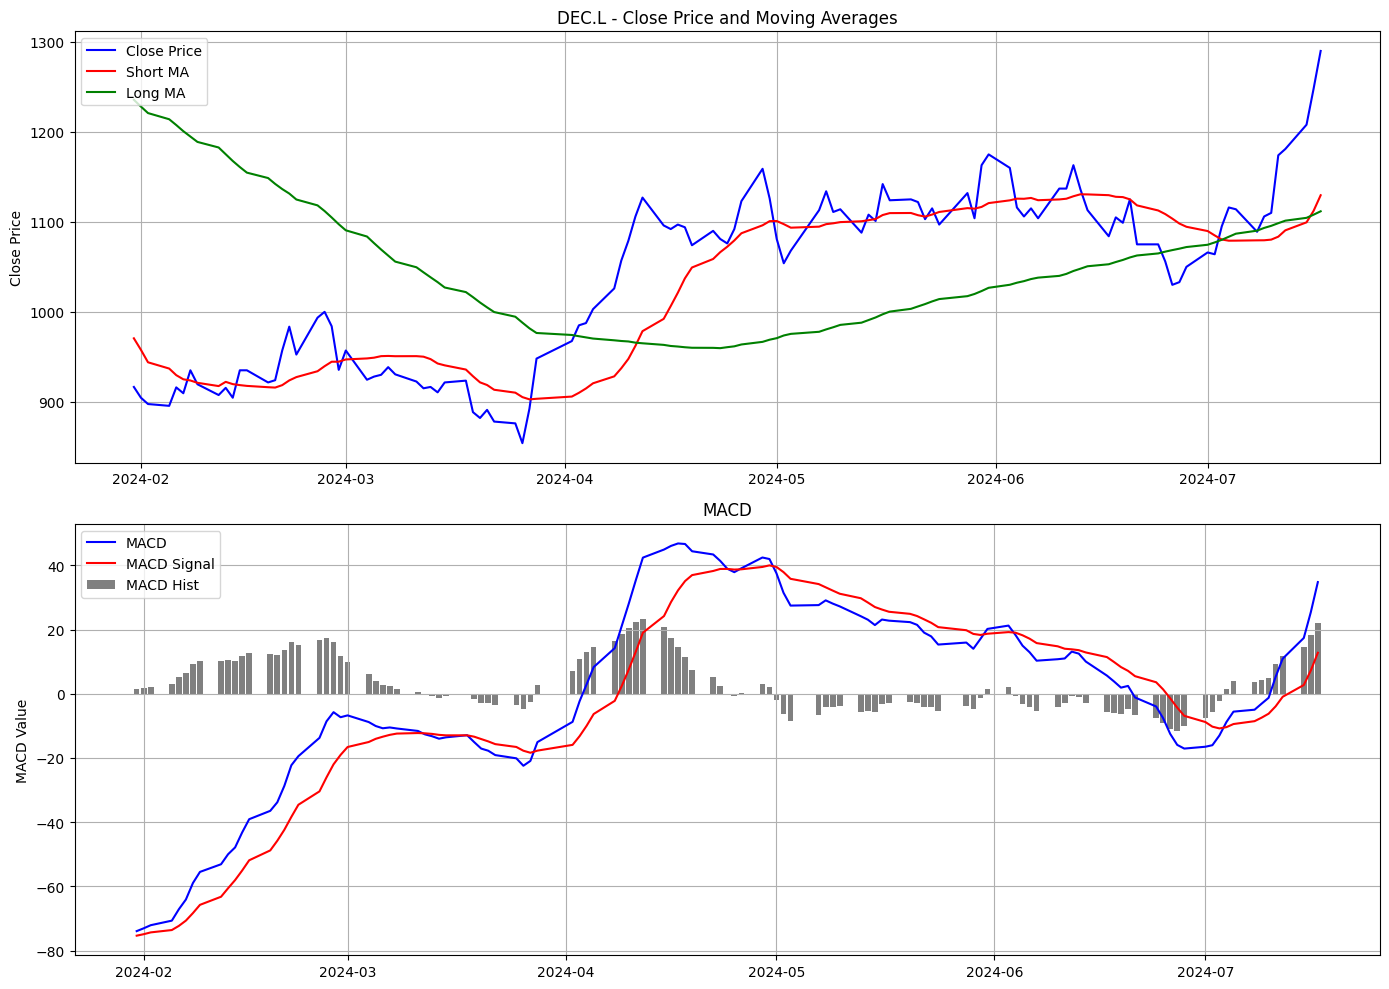

Ticker:                   DEC.L
Company:                  DIVERSIFIED ENERGY COMPANY PLC 
Sector:                   Energy
Industry:                 Oil & Gas E&P
Market Cap:               £602,851,968
Shares Outstanding:       47,263,900
52-Week High:             1930.0
52-Week Low:              822.5
PE Ratio (TTM):           1.0403768
EPS (TTM):                12.26
Dividend Yield:           0.0719
Payout Ratio:             0.2185
Revenue (TTM):            £806,788,992
Gross Profit (TTM):       N/A
Net Income (TTM):         £758,017,984
Total Debt:               £1,307,748,992
Operating Cash Flow (TTM): £410,132,000
Free Cash Flow (TTM):     £218,629,120

Description:              Diversified Energy Company PLC operates as an independent owner and operator of producing natural gas and oil wells primarily in the Appalachian Basin of the United States. The company is involved in the production, marketing, and transportation of natural gas, natural gas liquids, crude oil, and condensat

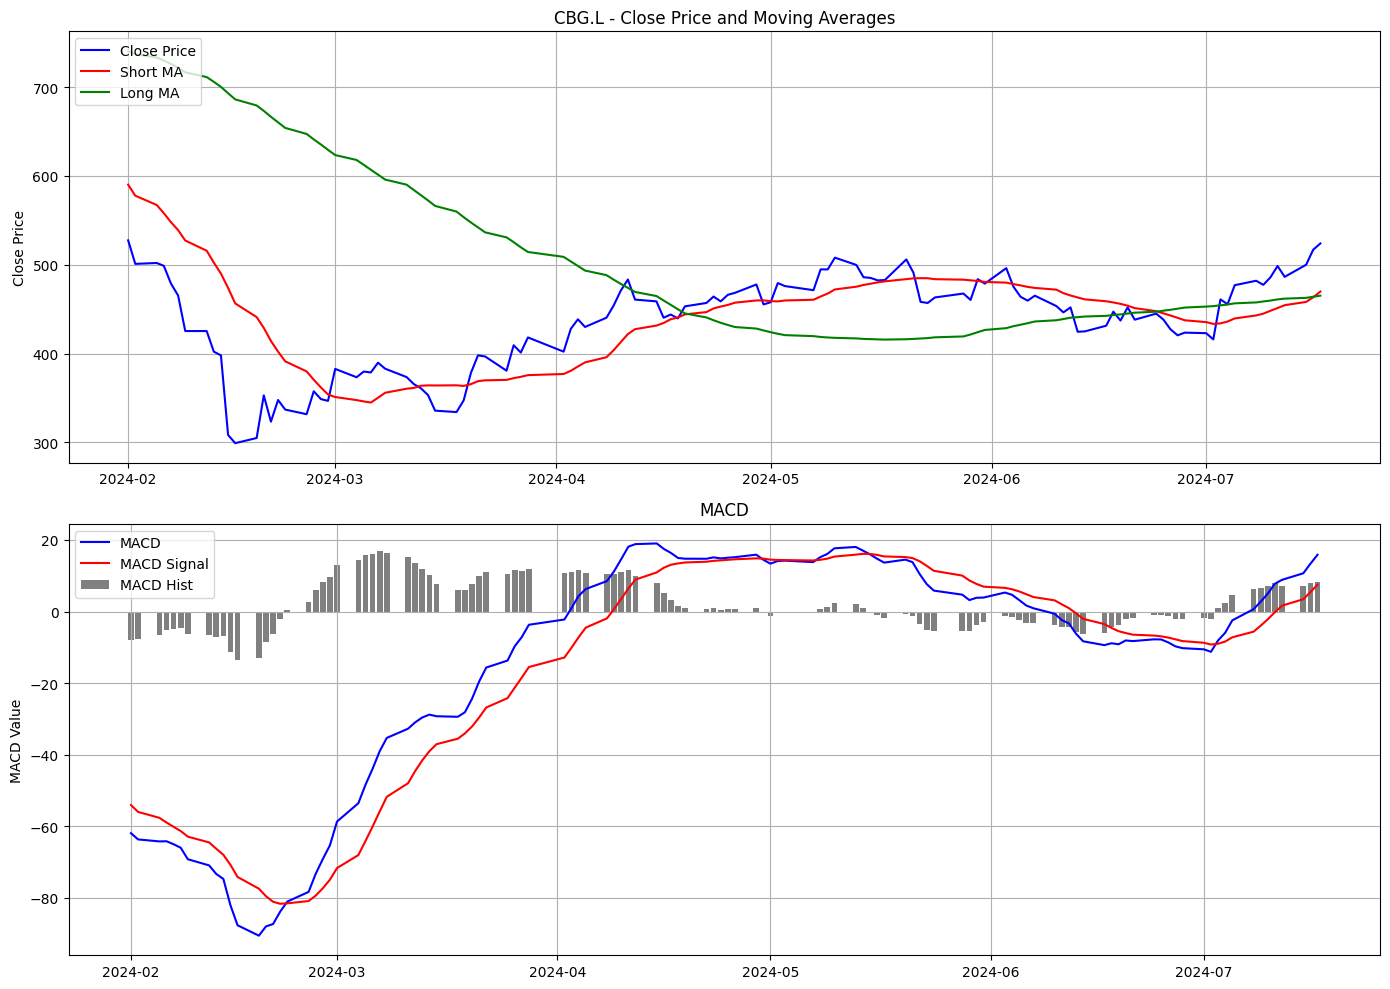

Ticker:                   CBG.L
Company:                  CLOSE BROTHERS GROUP PLC ORD 25
Sector:                   Financial Services
Industry:                 Banks - Regional
Market Cap:               £797,586,368
Shares Outstanding:       150,488,000
52-Week High:             979.0
52-Week Low:              278.0
PE Ratio (TTM):           5.5789475
EPS (TTM):                0.95
Dividend Yield:           0.1696
Payout Ratio:             0.71349996
Revenue (TTM):            £925,000,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £141,500,000
Total Debt:               £2,653,700,096
Operating Cash Flow (TTM): £-1,204,899,968
Free Cash Flow (TTM):     N/A

Description:              Close Brothers Group plc, a merchant banking company, engages in the provision of financial services to small businesses and individuals in the United Kingdom. It operates through five segments: Commercial, Retail, Property, Asset Management, and Securities. The company offers banking services 

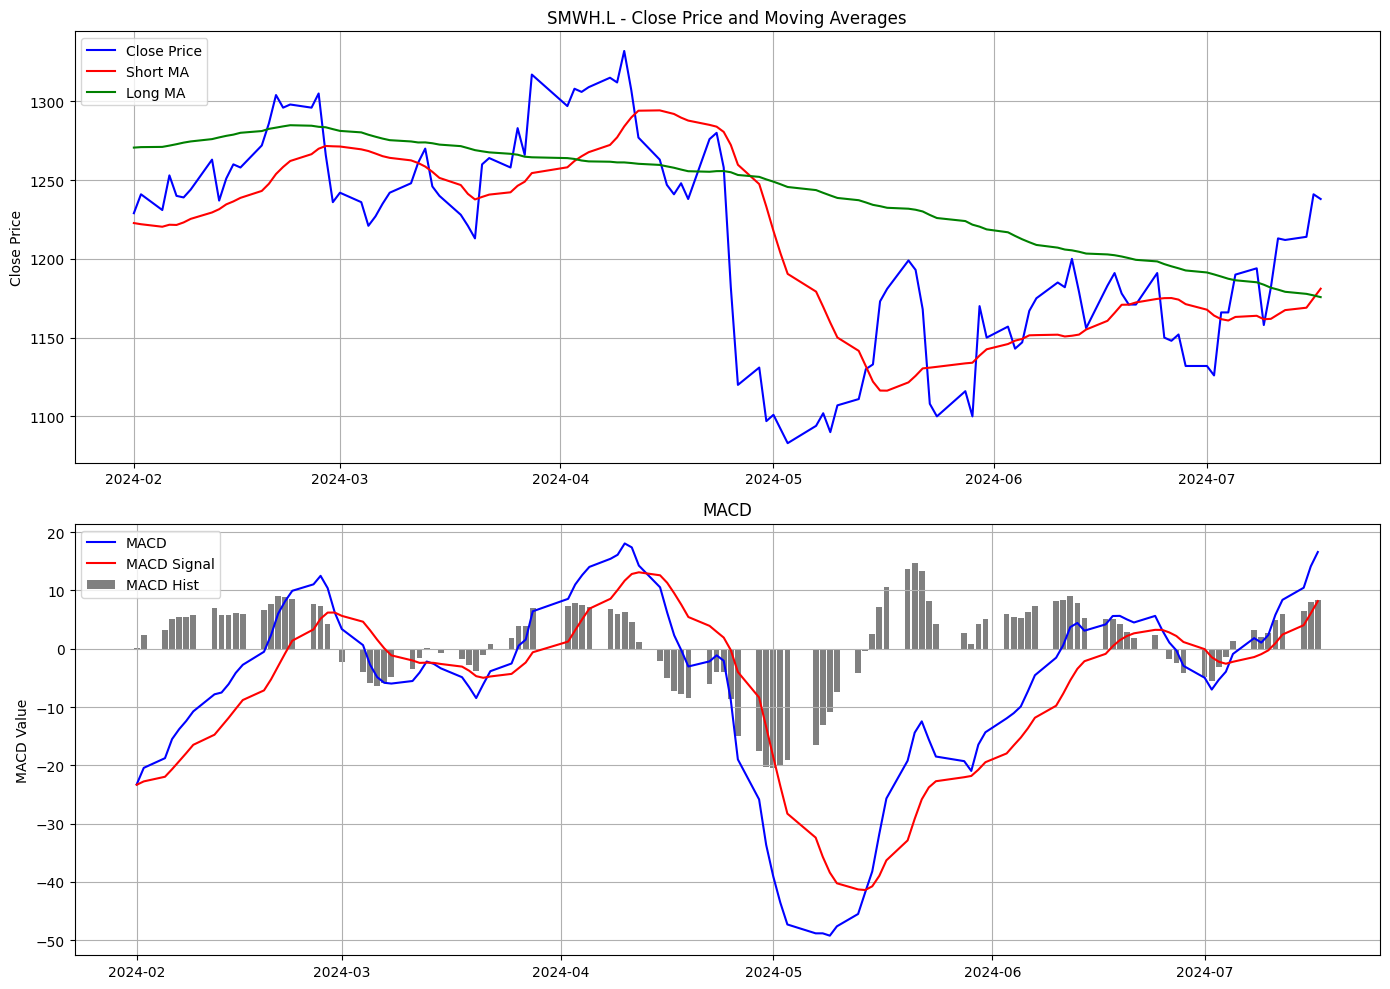

Ticker:                   SMWH.L
Company:                  WH SMITH PLC ORD 22 6/67P
Sector:                   Consumer Cyclical
Industry:                 Specialty Retail
Market Cap:               £1,669,128,064
Shares Outstanding:       130,912,000
52-Week High:             1562.0
52-Week Low:              1069.0
PE Ratio (TTM):           26.020407
EPS (TTM):                0.49
Dividend Yield:           0.0249
Payout Ratio:             0.5934
Revenue (TTM):            £1,860,000,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £64,000,000
Total Debt:               £1,083,000,064
Operating Cash Flow (TTM): £262,000,000
Free Cash Flow (TTM):     £82,000,000

Description:              WH Smith PLC operates as a retailer in the United Kingdom and internationally. It operates in two segments, Travel and High Street. The Travel segment offers news, books, and convenience for travelling customers. It operates stores in airports, hospitals, railway stations, and motorway service 

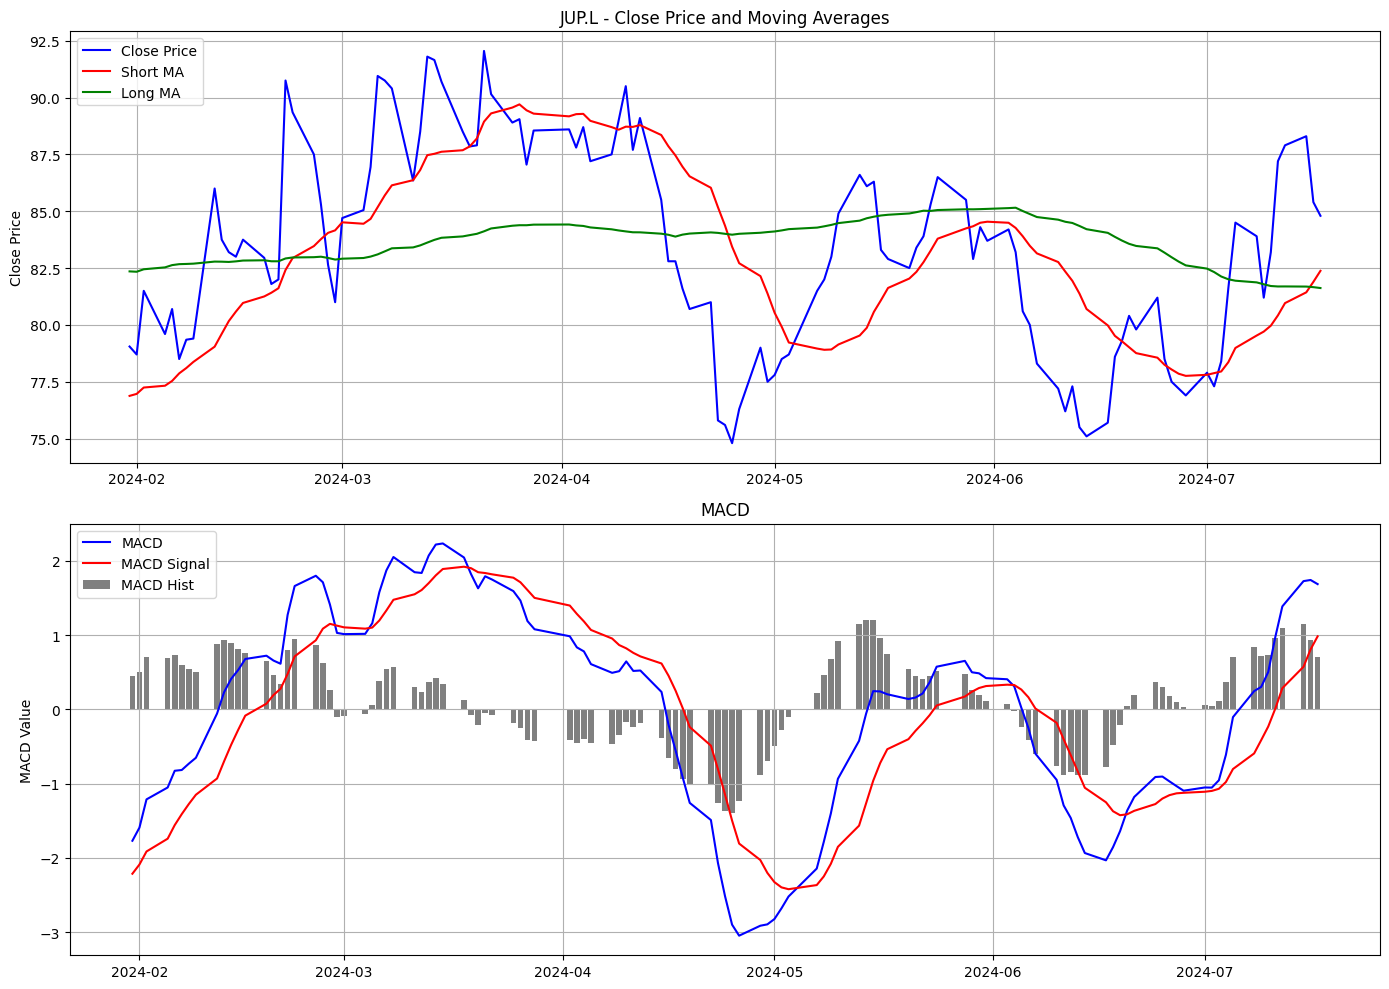

Ticker:                   JUP.L
Company:                  JUPITER FUND MANAGEMENT PLC ORD
Sector:                   Financial Services
Industry:                 Asset Management
Market Cap:               £433,395,872
Shares Outstanding:       511,080,000
52-Week High:             128.3
52-Week Low:              71.1
PE Ratio (TTM):           N/A
EPS (TTM):                -0.02
Dividend Yield:           0.0793
Payout Ratio:             0.77059996
Revenue (TTM):            £368,800,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £-12,900,000
Total Debt:               £93,800,000
Operating Cash Flow (TTM): £88,000,000
Free Cash Flow (TTM):     £127,800,000

Description:              Jupiter Fund Management Plc is a publicly owned investment manager. The firm manages mutual funds, hedge funds, client focused portfolios, and multi-manager products for its clients. It invests in the public equity markets across U.K., Europe and global emerging markets. The firm also invests in fi

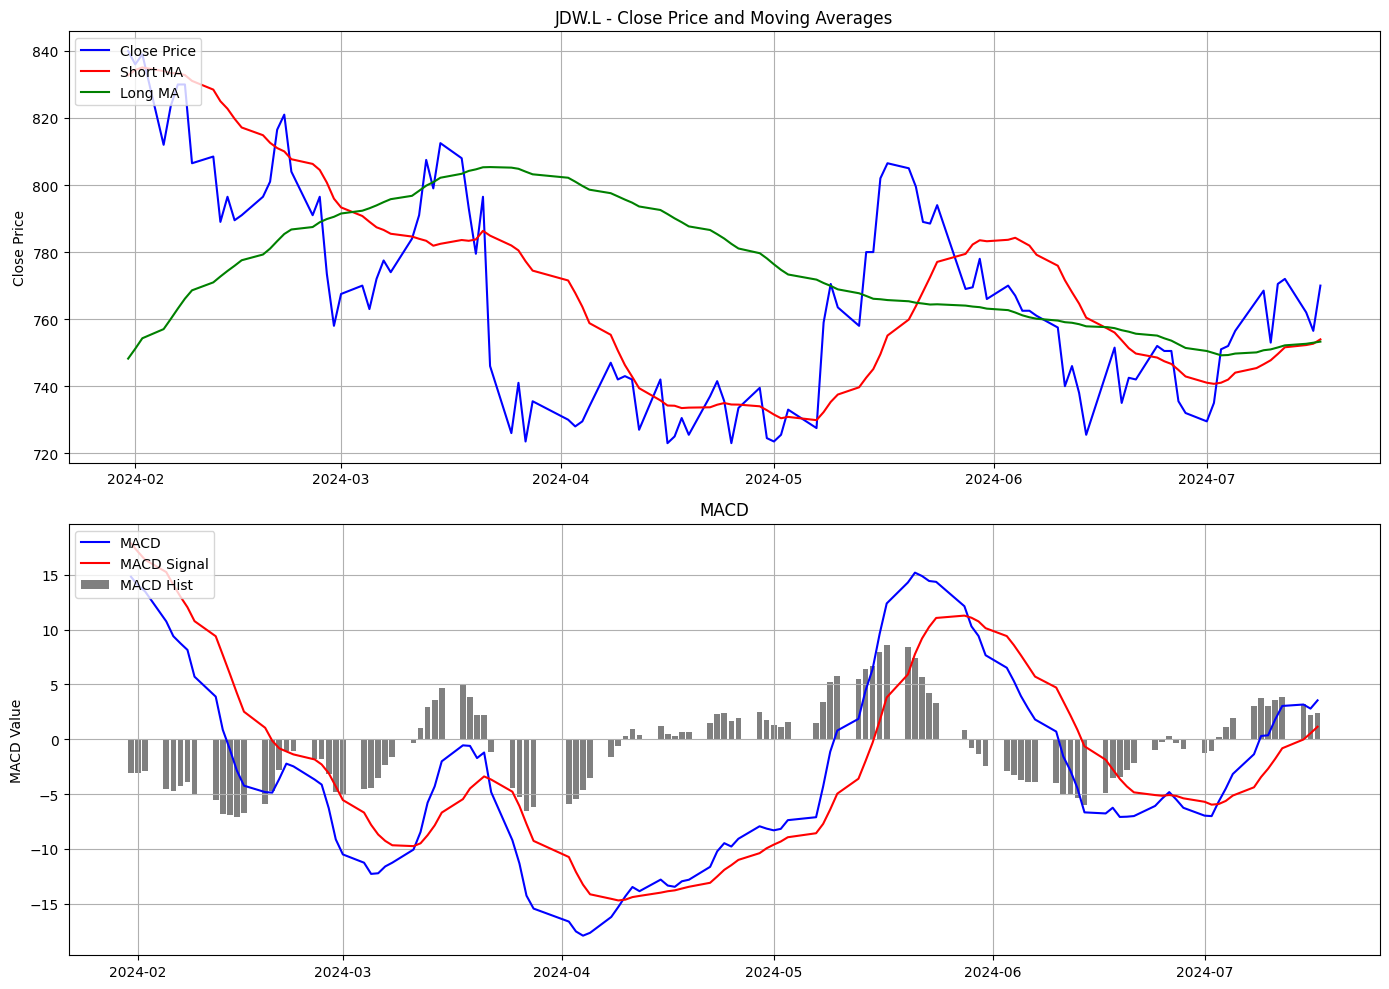

Ticker:                   JDW.L
Company:                  WETHERSPOON ( J.D.) PLC ORD 2P
Sector:                   Consumer Cyclical
Industry:                 Restaurants
Market Cap:               £910,476,032
Shares Outstanding:       123,622,000
52-Week High:             862.5
52-Week Low:              587.0
PE Ratio (TTM):           23.015625
EPS (TTM):                0.32
Dividend Yield:           N/A
Payout Ratio:             0.0
Revenue (TTM):            £2,000,041,984
Gross Profit (TTM):       N/A
Net Income (TTM):         £41,320,000
Total Debt:               £1,172,439,040
Operating Cash Flow (TTM): £200,751,008
Free Cash Flow (TTM):     £-308,571,008

Description:              J D Wetherspoon plc owns and operates pubs and hotels in the United Kingdom and the Republic of Ireland. The company was founded in 1979 and is based in Watford, the United Kingdom.


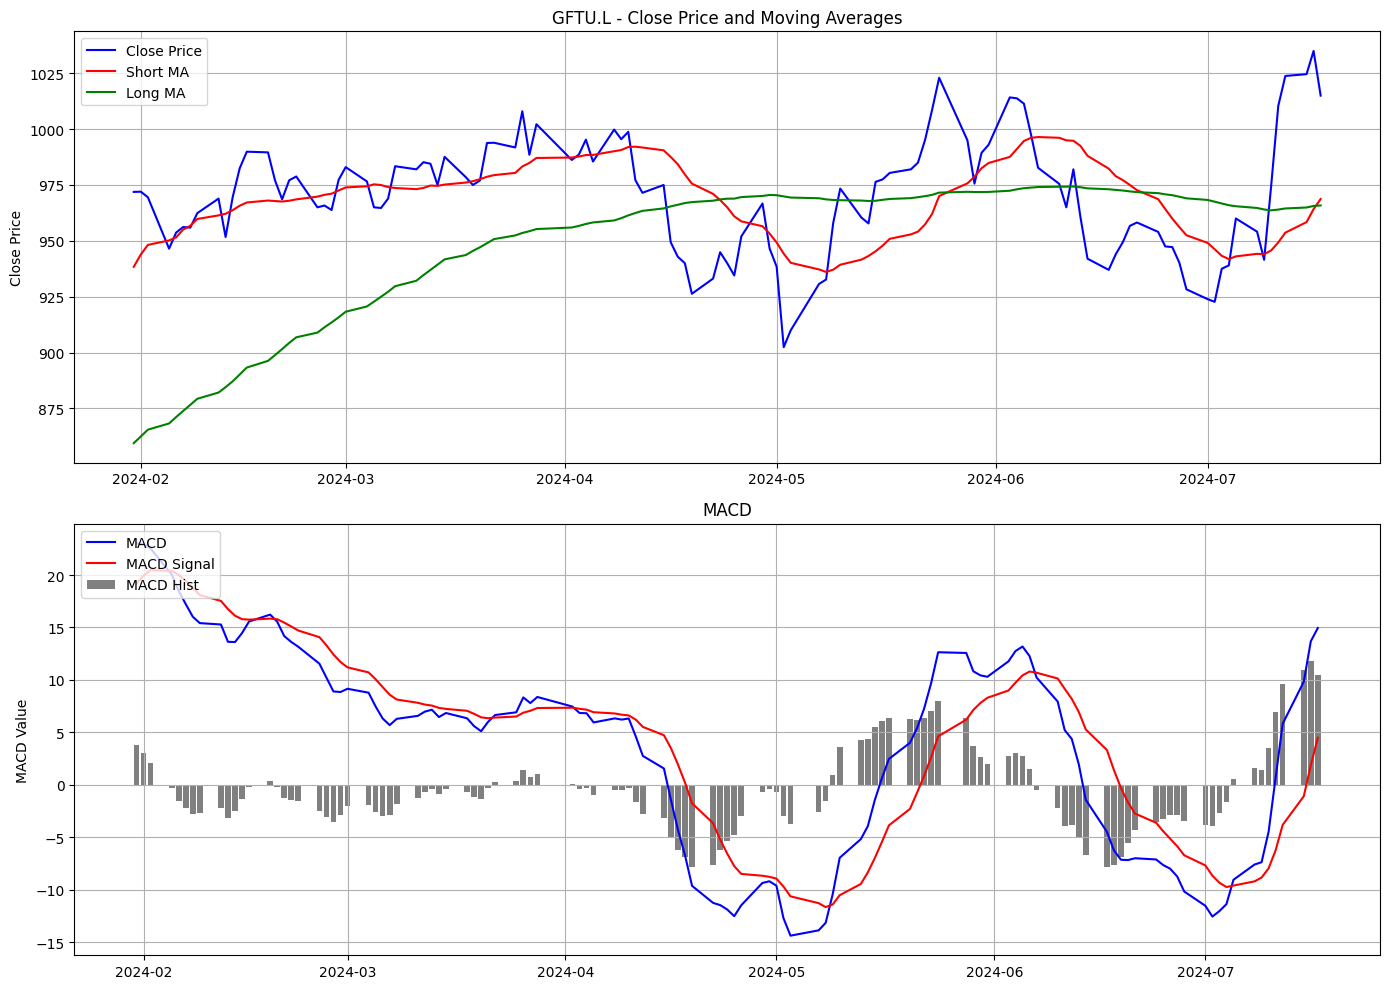

Ticker:                   GFTU.L
Company:                  GRAFTON GROUP PLC UT (1 ORD) (C
Sector:                   Industrials
Industry:                 Industrial Distribution
Market Cap:               £2,038,476,160
Shares Outstanding:       200,086,000
52-Week High:             1040.0
52-Week Low:              737.2
PE Ratio (TTM):           12.1285715
EPS (TTM):                0.84
Dividend Yield:           0.035
Payout Ratio:             0.36450002
Revenue (TTM):            £2,319,241,984
Gross Profit (TTM):       N/A
Net Income (TTM):         £148,723,008
Total Debt:               £633,201,984
Operating Cash Flow (TTM): £272,816,992
Free Cash Flow (TTM):     £199,337,376

Description:              Grafton Group plc engages in the distribution, retailing, and manufacturing businesses in Ireland, the Netherlands, Finland, and the United Kingdom. Its Distribution segment distributes building materials, paint, tools, ironmongery, fixings, and accessories, workwear and PPE, and spar

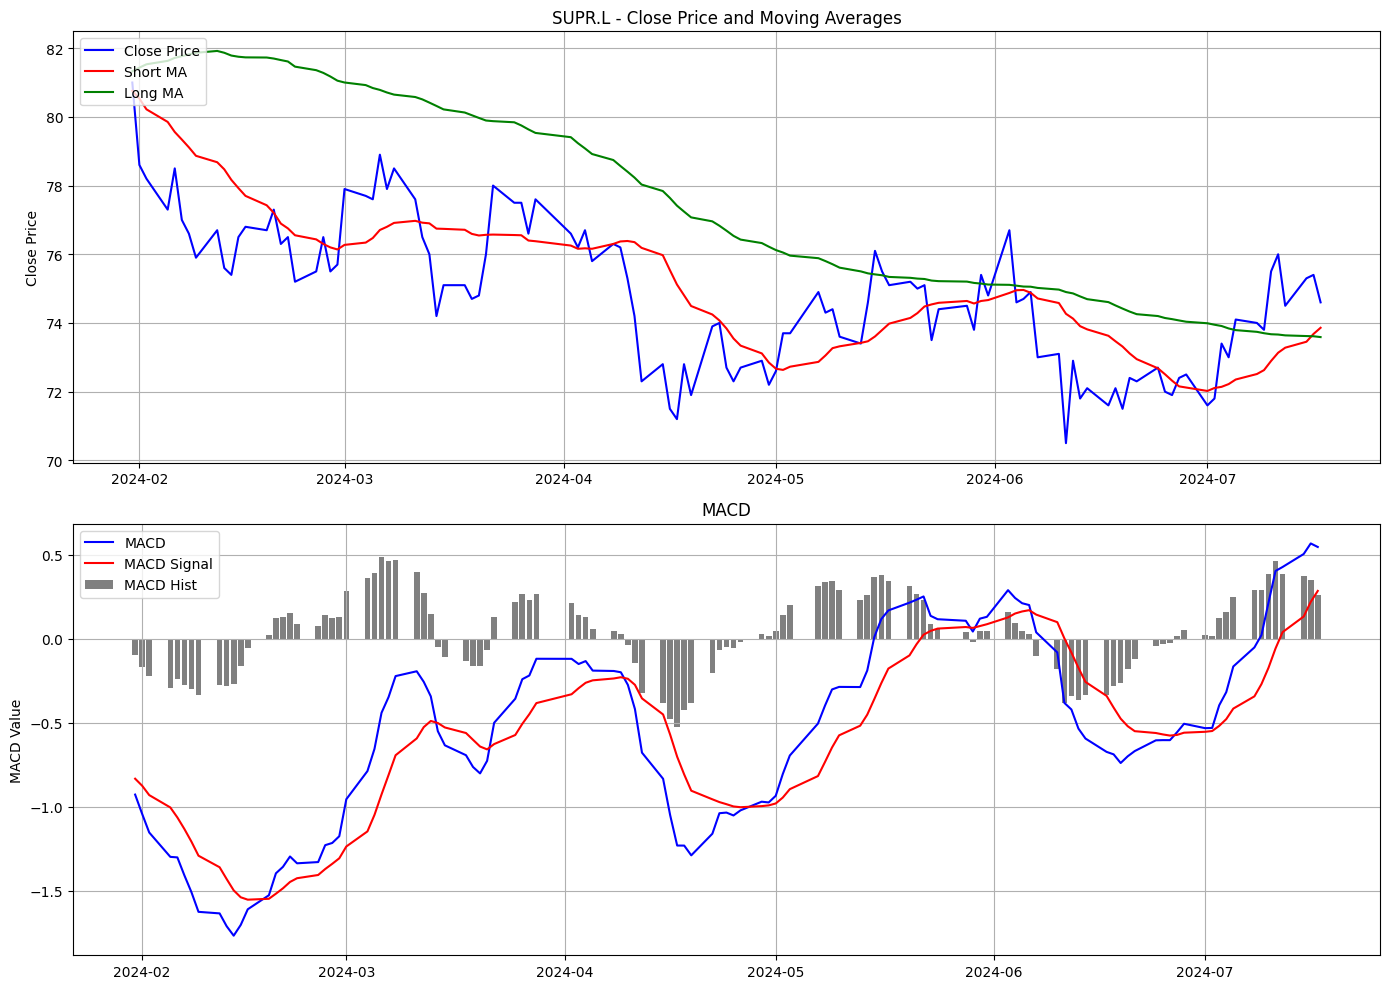

Ticker:                   SUPR.L
Company:                  SUPERMARKET INCOME REIT PLC ORD
Sector:                   N/A
Industry:                 N/A
Market Cap:               £934,680,000
Shares Outstanding:       N/A
52-Week High:             88.8
52-Week Low:              69.5
PE Ratio (TTM):           Infinity
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A


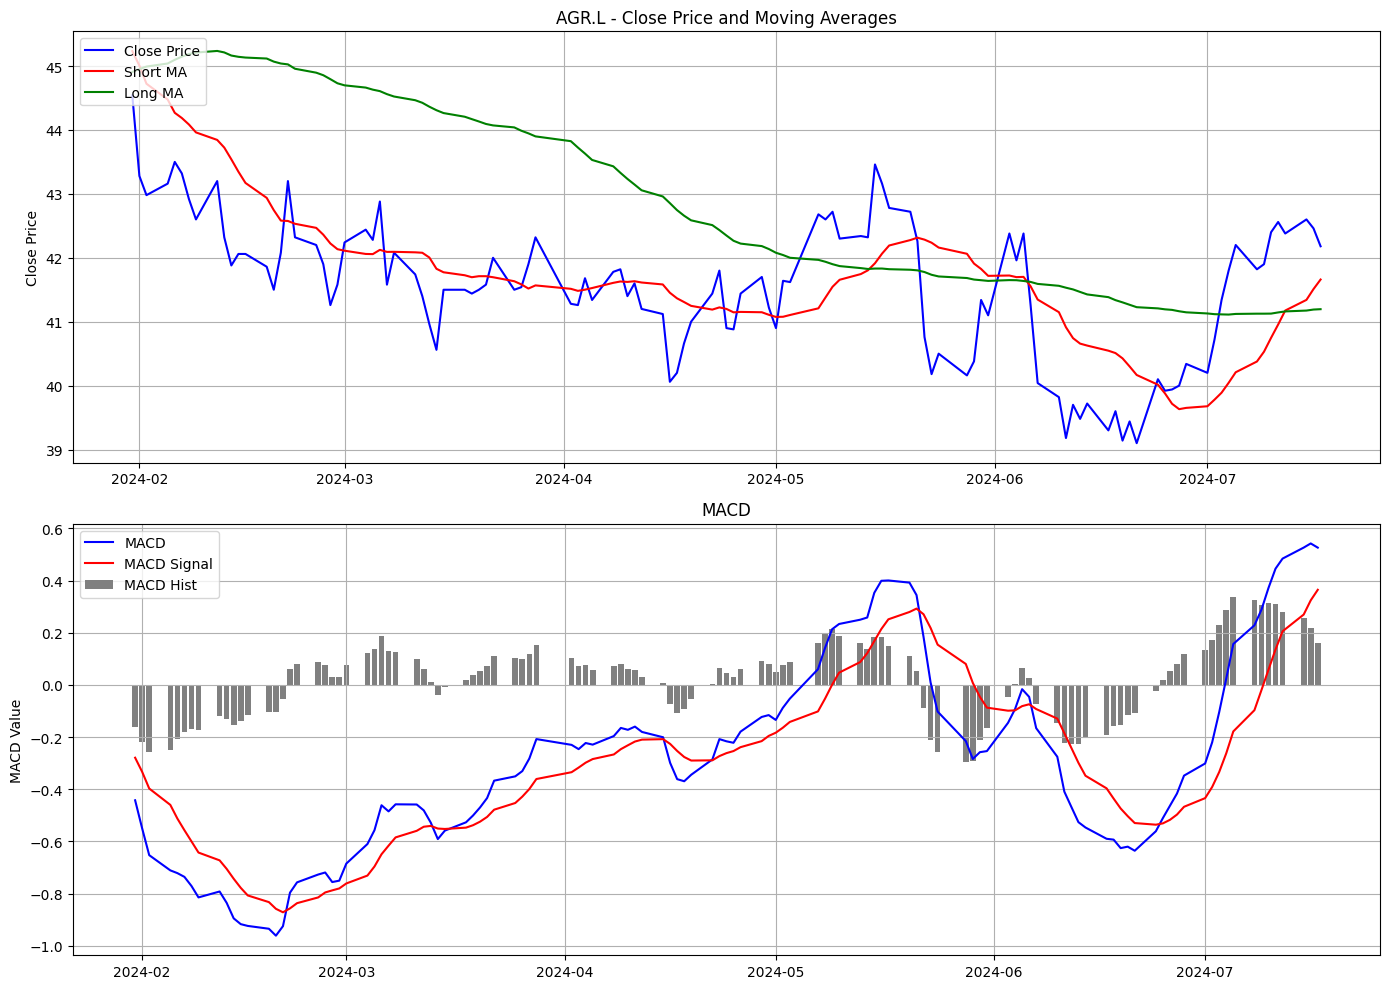

Ticker:                   AGR.L
Company:                  ASSURA PLC ORD 10P
Sector:                   Real Estate
Industry:                 REIT - Healthcare Facilities
Market Cap:               £1,245,419,008
Shares Outstanding:       2,990,919,936
52-Week High:             49.92
52-Week Low:              37.54
PE Ratio (TTM):           N/A
EPS (TTM):                -0.01
Dividend Yield:           0.0798
Payout Ratio:             0.76
Revenue (TTM):            £157,800,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £-28,800,000
Total Debt:               £1,252,800,000
Operating Cash Flow (TTM): £102,400,000
Free Cash Flow (TTM):     £64,462,500

Description:              Assura plc is a national healthcare premises specialist and UK REIT based in Altrincham, UK - caring for more than 600 primary healthcare buildings, from which over six million patients are served. A constituent of the FTSE 250 and the EPRA indices, as at 30 September 2023, Assura's portfolio was valued 

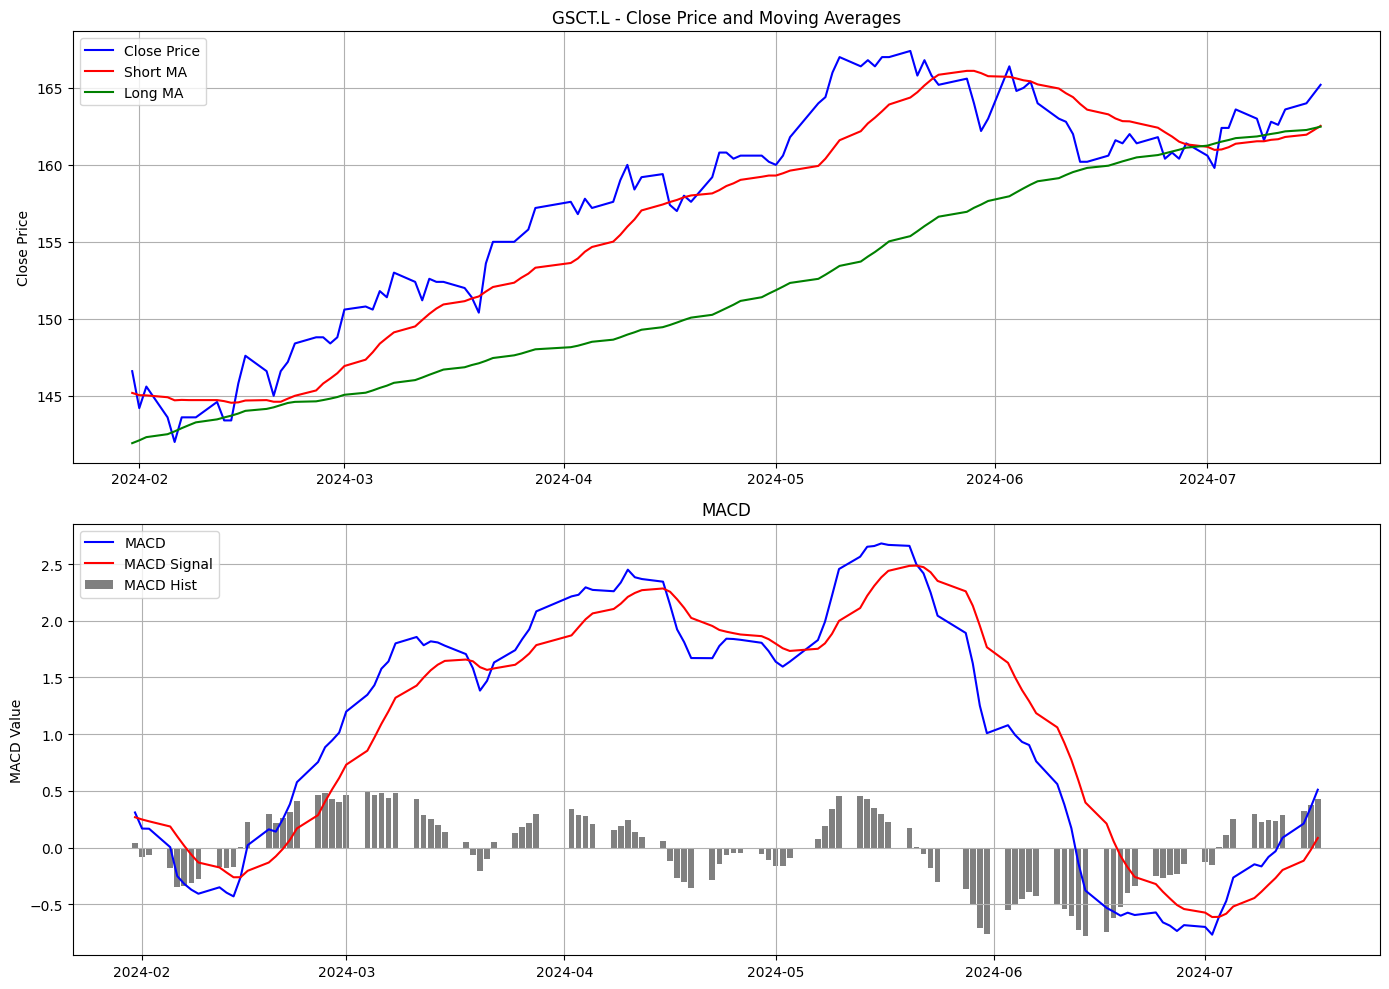

Ticker:                   GSCT.L
Company:                  THE GLOBAL SMALLER COMPANIES TR
Sector:                   N/A
Industry:                 N/A
Market Cap:               £792,220,608
Shares Outstanding:       N/A
52-Week High:             176.5
52-Week Low:              128.2
PE Ratio (TTM):           12.63077
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A


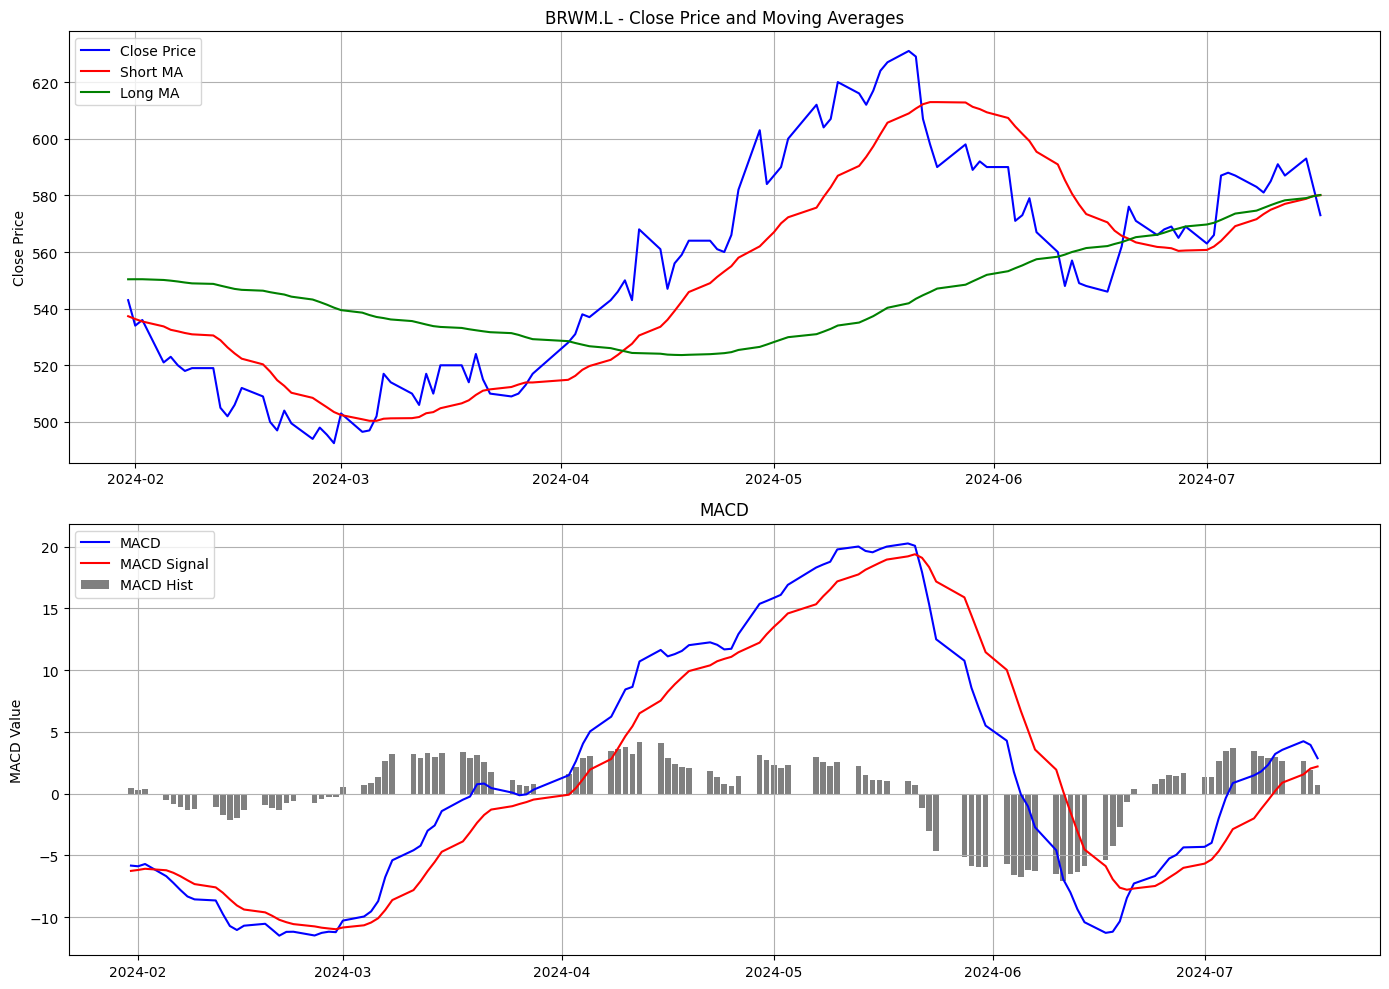

Ticker:                   BRWM.L
Company:                  BLACKROCK WORLD MINING TRUST PL
Sector:                   N/A
Industry:                 N/A
Market Cap:               £1,063,125,504
Shares Outstanding:       N/A
52-Week High:             635.0
52-Week Low:              490.0
PE Ratio (TTM):           N/A
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A


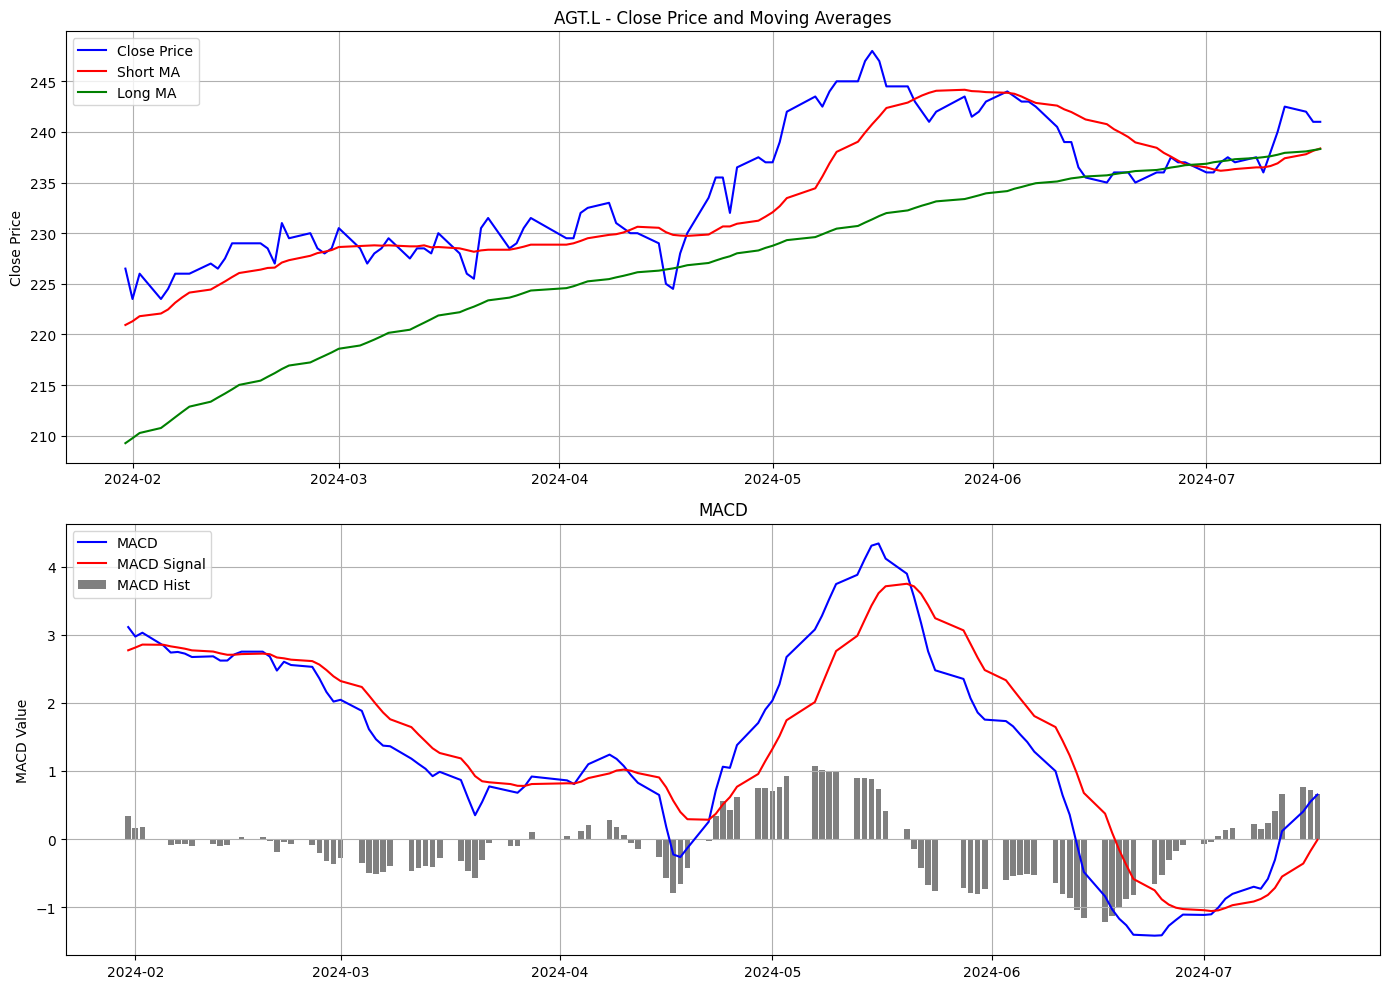

Ticker:                   AGT.L
Company:                  AVI GLOBAL TRUST PLC ORD 2P
Sector:                   N/A
Industry:                 N/A
Market Cap:               £1,080,178,304
Shares Outstanding:       N/A
52-Week High:             255.21
52-Week Low:              186.0
PE Ratio (TTM):           4.9417386
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A


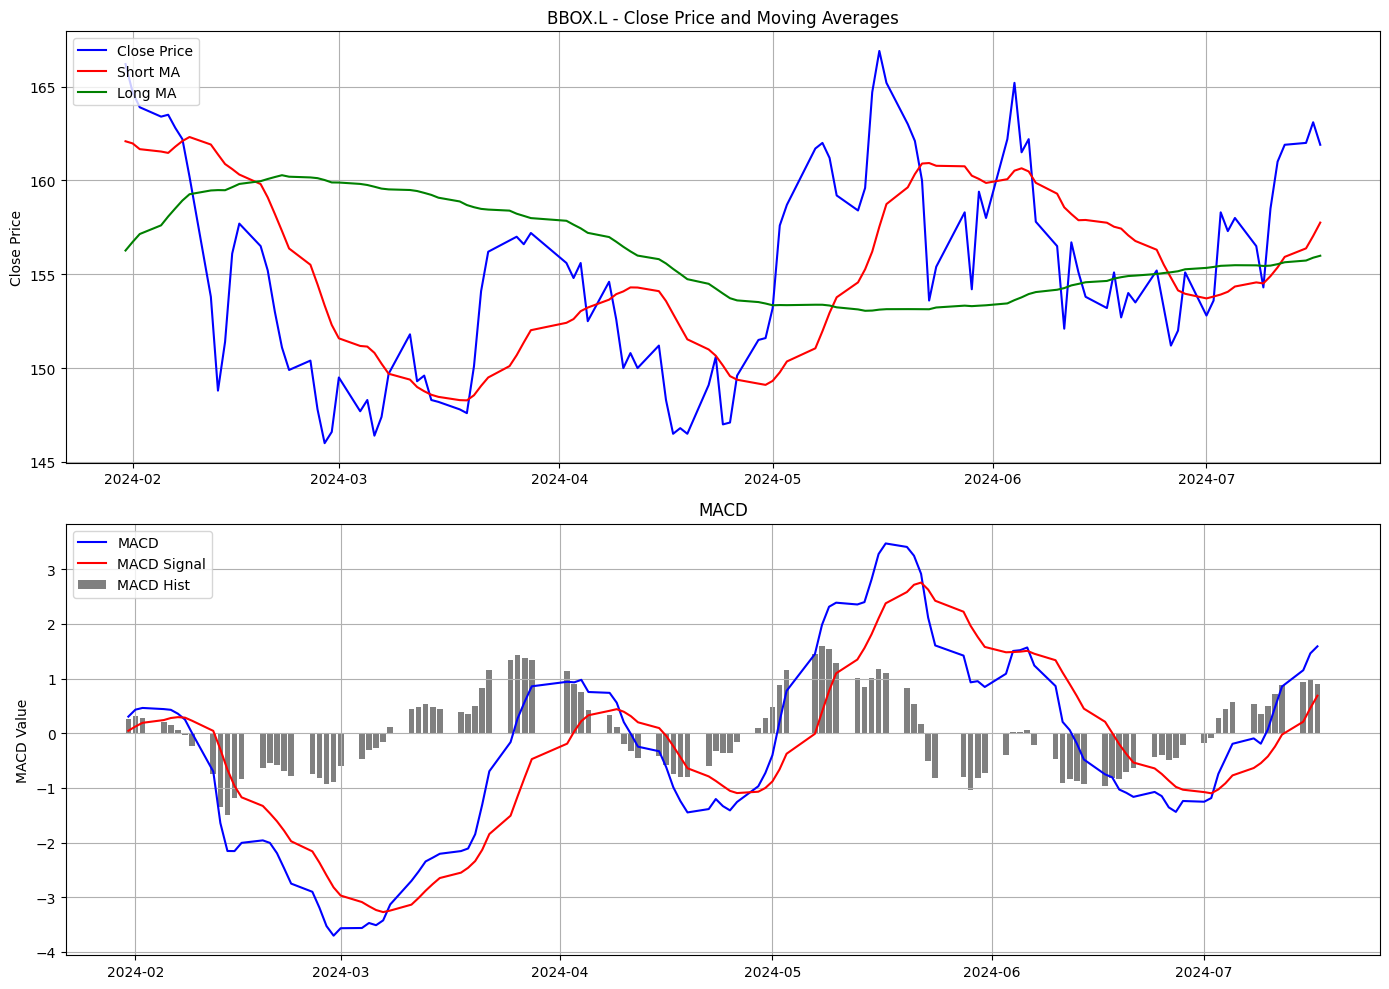

Ticker:                   BBOX.L
Company:                  TRITAX BIG BOX REIT PLC ORD 1P
Sector:                   N/A
Industry:                 N/A
Market Cap:               £4,003,817,472
Shares Outstanding:       N/A
52-Week High:             173.0
52-Week Low:              127.1
PE Ratio (TTM):           40.35
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A


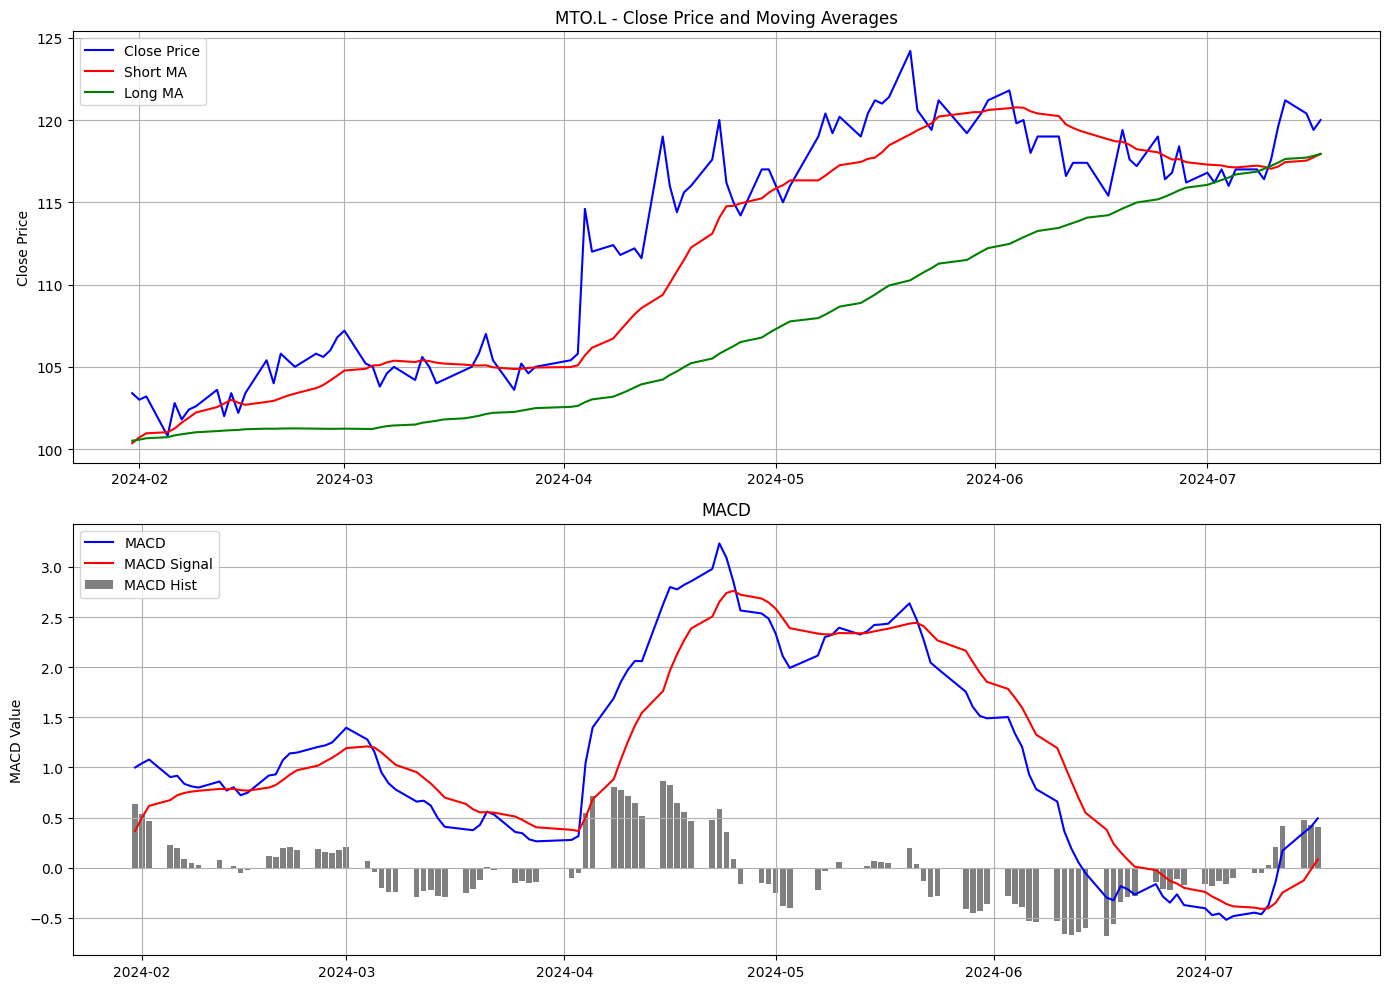

Ticker:                   MTO.L
Company:                  MITIE GROUP PLC ORD 2.5P
Sector:                   Industrials
Industry:                 Specialty Business Services
Market Cap:               £1,523,362,688
Shares Outstanding:       1,256,400,000
52-Week High:             124.939
52-Week Low:              90.7
PE Ratio (TTM):           13.466666
EPS (TTM):                0.09
Dividend Yield:           0.0328
Payout Ratio:             0.3516
Revenue (TTM):            £4,445,199,872
Gross Profit (TTM):       N/A
Net Income (TTM):         £126,300,000
Total Debt:               £321,500,000
Operating Cash Flow (TTM): £197,700,000
Free Cash Flow (TTM):     £203,175,008

Description:              Mitie Group plc, together with its subsidiaries, provides facilities management and professional services in the United Kingdom and internationally. The company operates in four segments: Business Services, Technical Services, Central Government & Defense (CG&D), Communities. The company pr

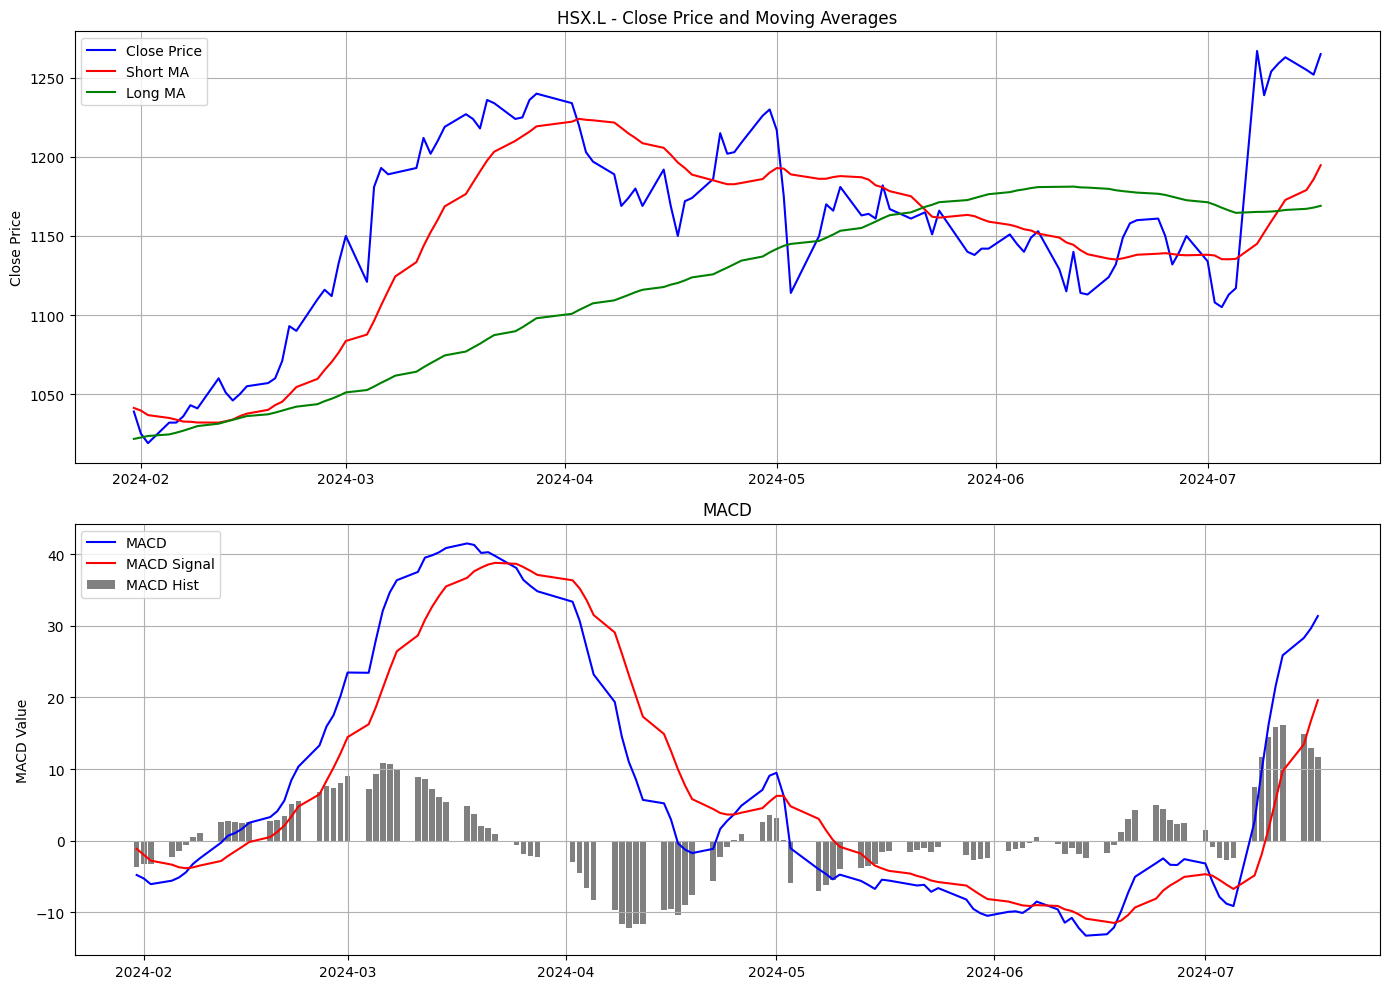

Ticker:                   HSX.L
Company:                  HISCOX LTD ORD 6.5P (DI)
Sector:                   Financial Services
Industry:                 Insurance - Property & Casualty
Market Cap:               £4,246,654,720
Shares Outstanding:       340,779,008
52-Week High:             1282.0
52-Week Low:              926.035
PE Ratio (TTM):           8.03871
EPS (TTM):                1.55
Dividend Yield:           0.0235
Payout Ratio:             0.1839
Revenue (TTM):            £3,699,599,872
Gross Profit (TTM):       N/A
Net Income (TTM):         £712,000,000
Total Debt:               £754,200,000
Operating Cash Flow (TTM): £232,100,000
Free Cash Flow (TTM):     £698,475,008

Description:              Hiscox Ltd, through its subsidiaries, provides insurance and reinsurance services in the United Kingdom, Europe, the United States, and internationally. The company operates through four segments: Hiscox Retail, Hiscox London Market, Hiscox Re & ILS, and Corporate Centre. It offers

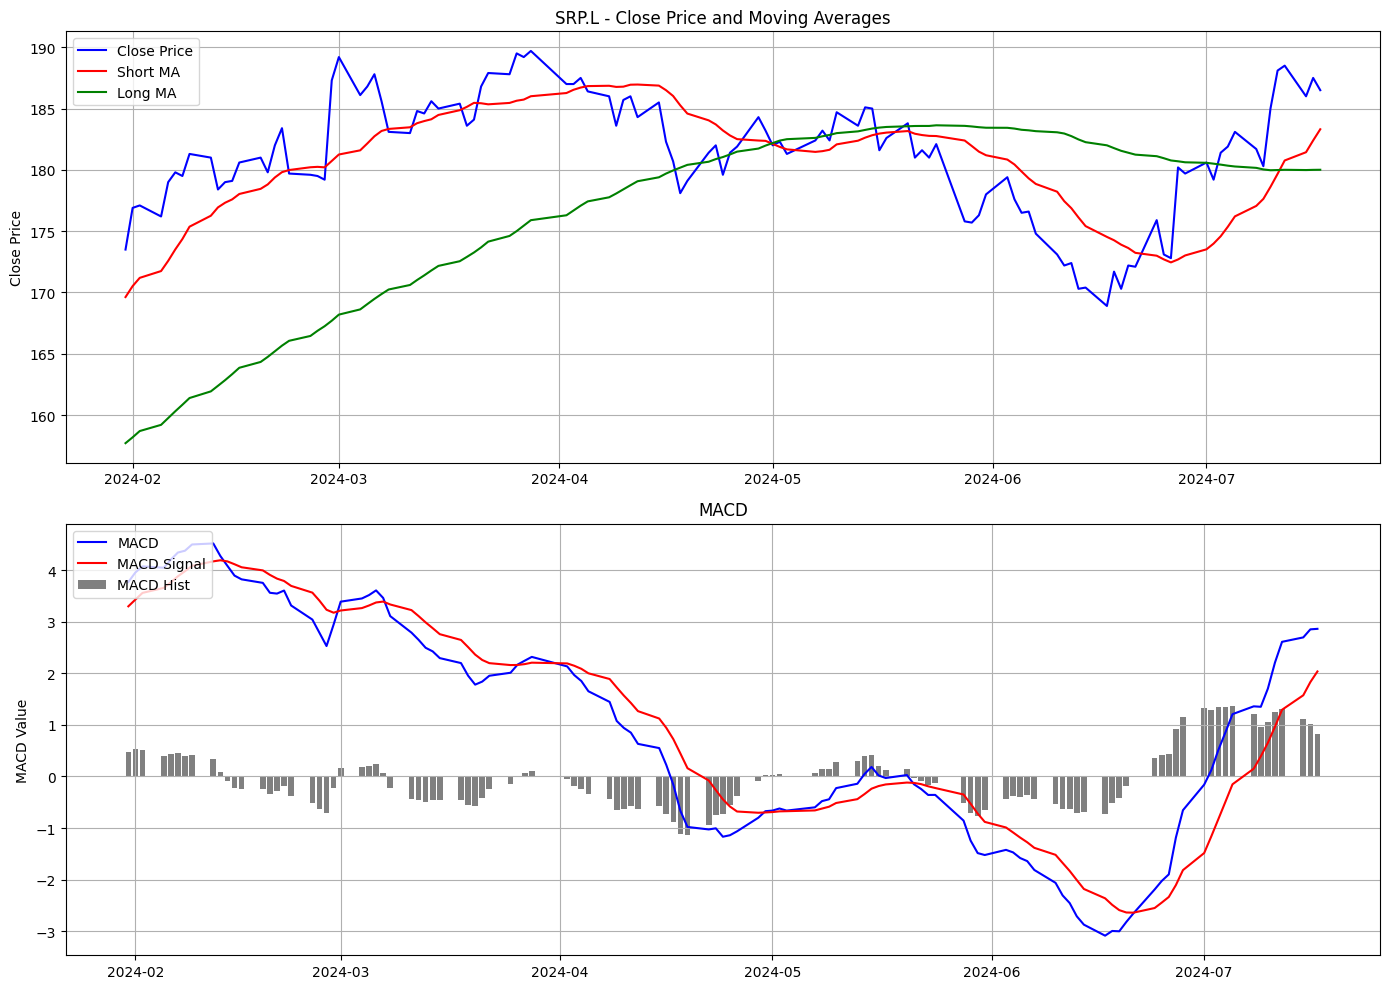

Ticker:                   SRP.L
Company:                  SERCO GROUP PLC ORD 2P
Sector:                   Industrials
Industry:                 Specialty Business Services
Market Cap:               £1,989,528,832
Shares Outstanding:       1,058,060,032
52-Week High:             193.1
52-Week Low:              138.0
PE Ratio (TTM):           10.444444
EPS (TTM):                0.18
Dividend Yield:           0.018099999
Payout Ratio:             0.1707
Revenue (TTM):            £4,873,800,192
Gross Profit (TTM):       N/A
Net Income (TTM):         £202,400,000
Total Debt:               £659,900,032
Operating Cash Flow (TTM): £393,100,000
Free Cash Flow (TTM):     £203,262,496

Description:              Serco Group plc provides public services in the United Kingdom, Europe, North America, the Asia Pacific, and the Middle East. It offers service design and advisory, resourcing, programmes management, systems integration, case management, engineering, and assets and facilities management s

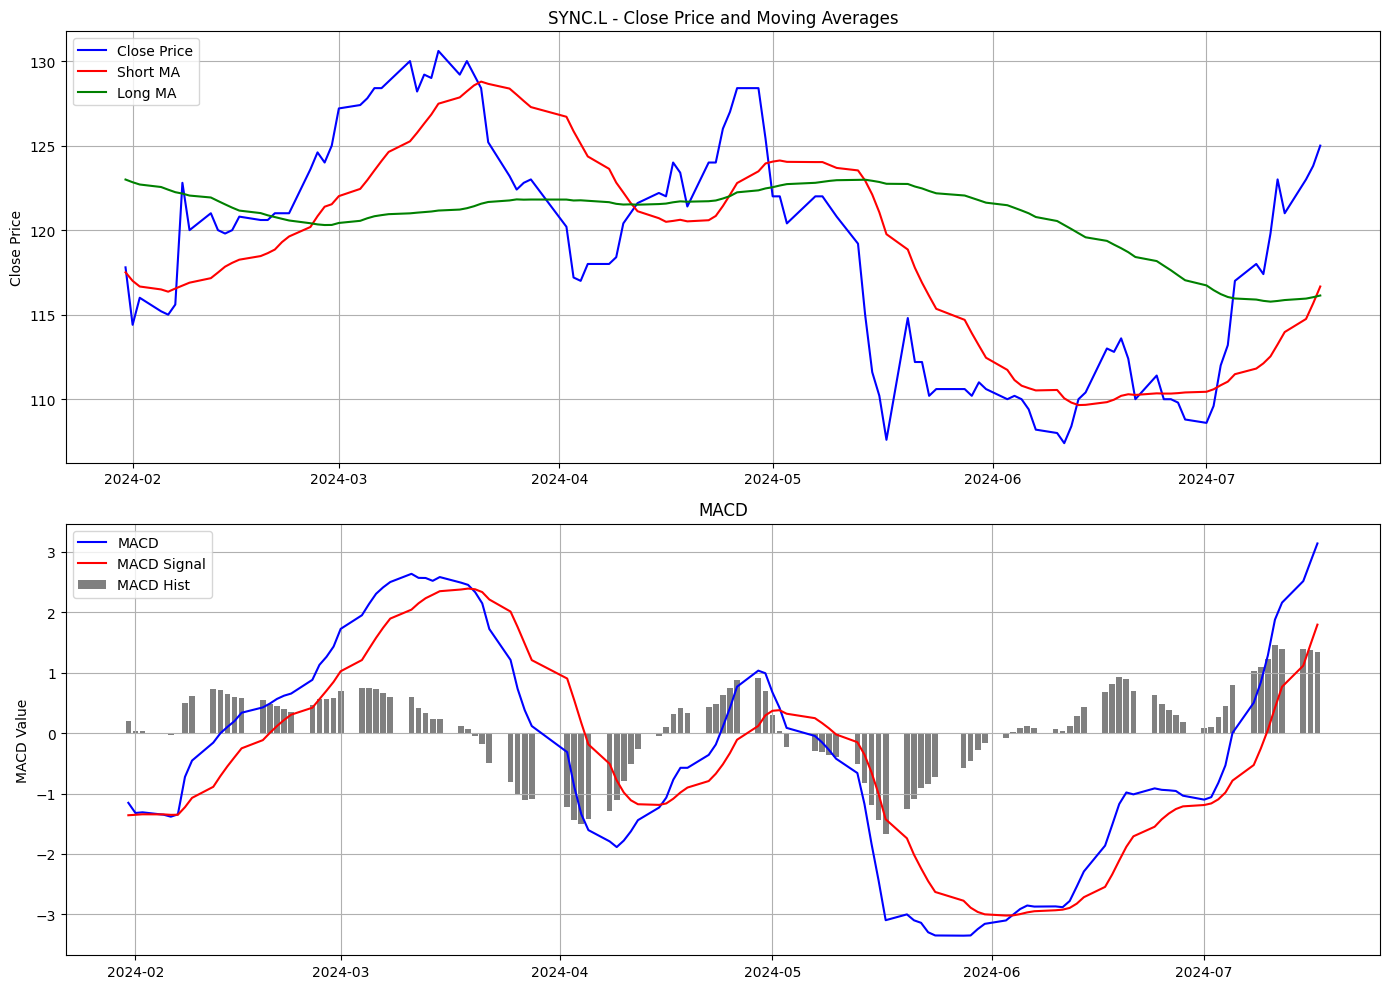

Ticker:                   SYNC.L
Company:                  SYNCONA LIMITED ORD NPV
Sector:                   N/A
Industry:                 N/A
Market Cap:               £805,783,808
Shares Outstanding:       N/A
52-Week High:             188.2
52-Week Low:              105.0
PE Ratio (TTM):           125.0
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A


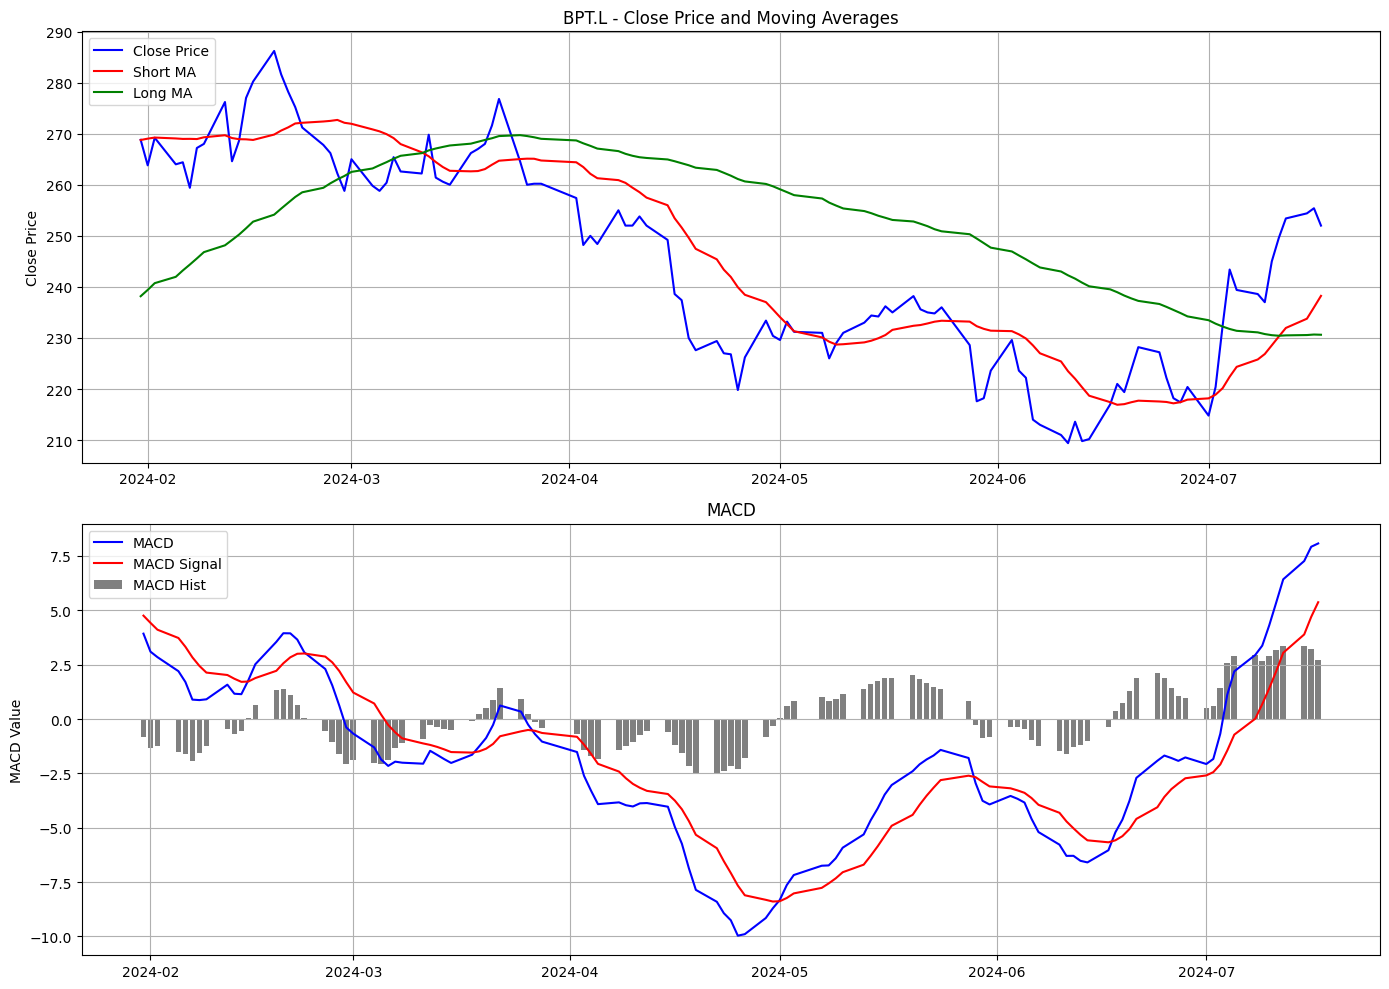

Ticker:                   BPT.L
Company:                  BRIDGEPOINT GROUP PLC ORD GBP0.
Sector:                   Financial Services
Industry:                 Asset Management
Market Cap:               £2,177,371,904
Shares Outstanding:       792,891,008
52-Week High:             300.6
52-Week Low:              164.8
PE Ratio (TTM):           30.51111
EPS (TTM):                0.09
Dividend Yield:           0.034
Payout Ratio:             0.9333
Revenue (TTM):            £321,600,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £70,700,000
Total Debt:               £110,100,000
Operating Cash Flow (TTM): £95,000,000
Free Cash Flow (TTM):     £-430,000,000

Description:              Bridgepoint Group plc is a private equity and private credit firm specializing in middle market, small mid cap, small cap, growth capital, buyouts investments, syndicate debt, direct lending and credit opportunities in private credit investments. It prefers to invest in advanced industrials, aut

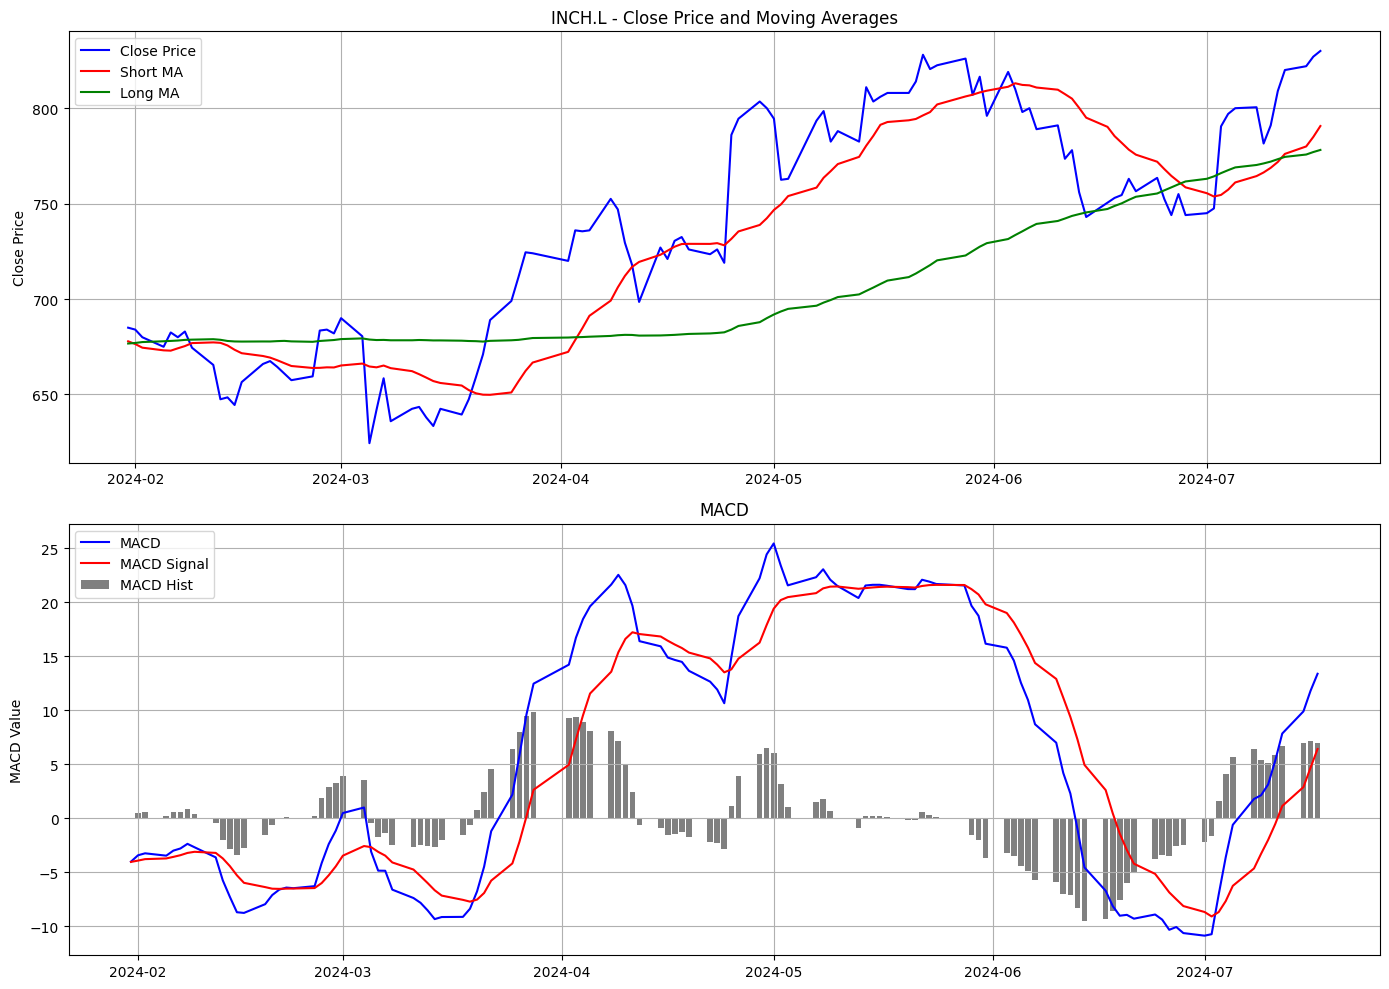

Ticker:                   INCH.L
Company:                  INCHCAPE PLC ORD 10P
Sector:                   Consumer Cyclical
Industry:                 Auto & Truck Dealerships
Market Cap:               £3,446,371,840
Shares Outstanding:       411,999,008
52-Week High:             892.5
52-Week Low:              597.5
PE Ratio (TTM):           12.869231
EPS (TTM):                0.65
Dividend Yield:           0.040900003
Payout Ratio:             0.47689998
Revenue (TTM):            £11,447,000,064
Gross Profit (TTM):       N/A
Net Income (TTM):         £270,000,000
Total Debt:               £3,607,000,064
Operating Cash Flow (TTM): £593,000,000
Free Cash Flow (TTM):     £-141,124,992

Description:              Inchcape plc operates as an automotive distributor and retailer. It engages in the distribution, sales, and marketing of new and used cars, and parts. The company also provides aftersales service and body shop repairs; and finance and insurance products and services, as well as pr

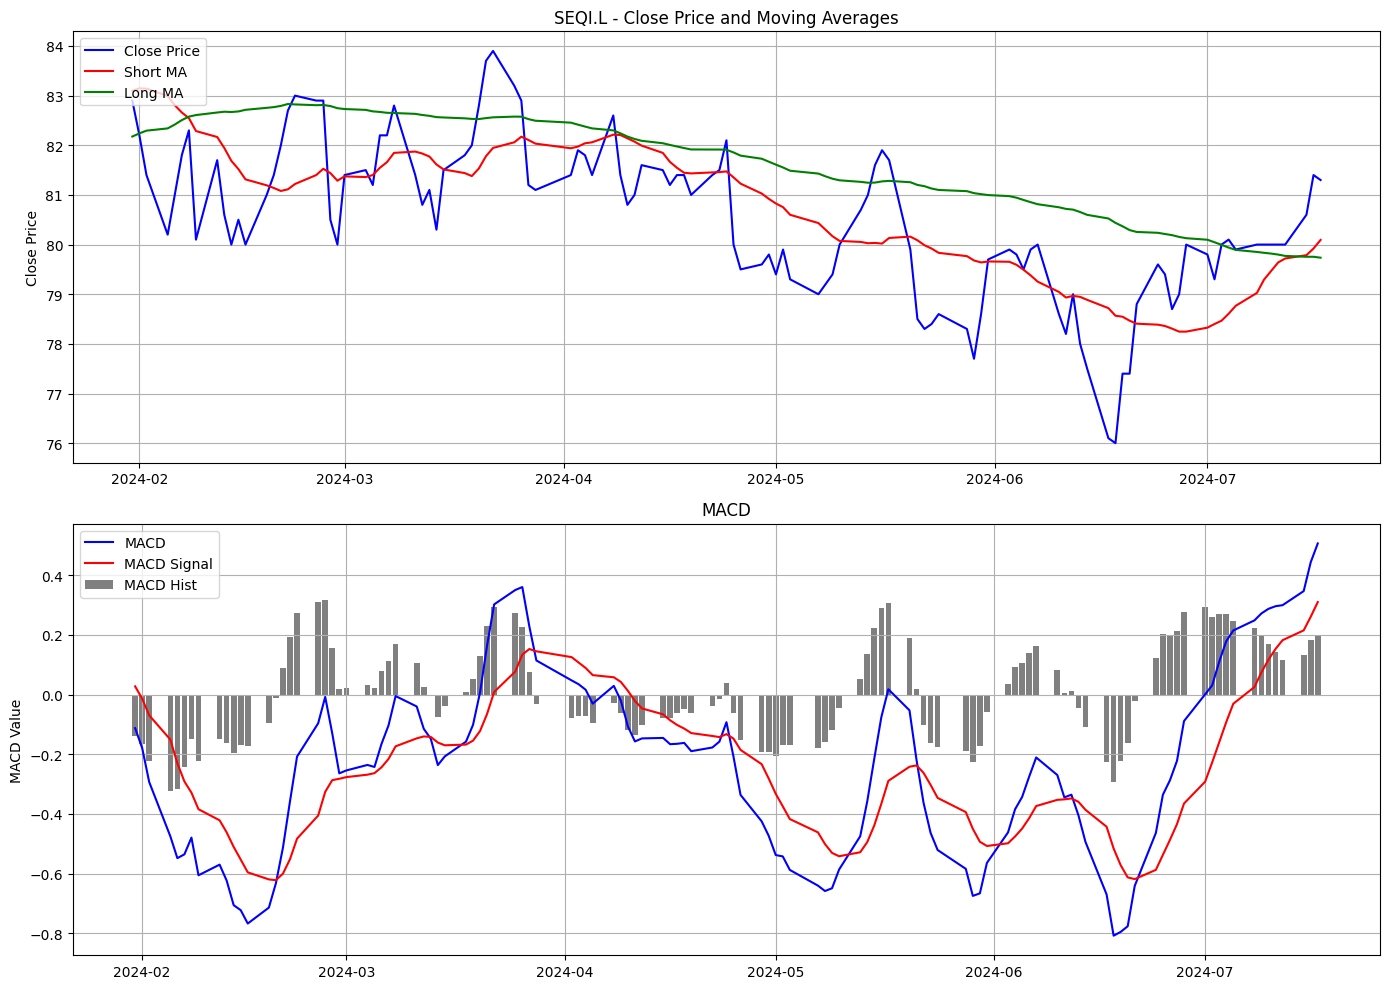

Ticker:                   SEQI.L
Company:                  SEQUOIA ECONOMIC INFRASTRUCTURE
Sector:                   N/A
Industry:                 N/A
Market Cap:               £1,297,838,592
Shares Outstanding:       N/A
52-Week High:             91.161
52-Week Low:              72.8
PE Ratio (TTM):           11.642857
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A


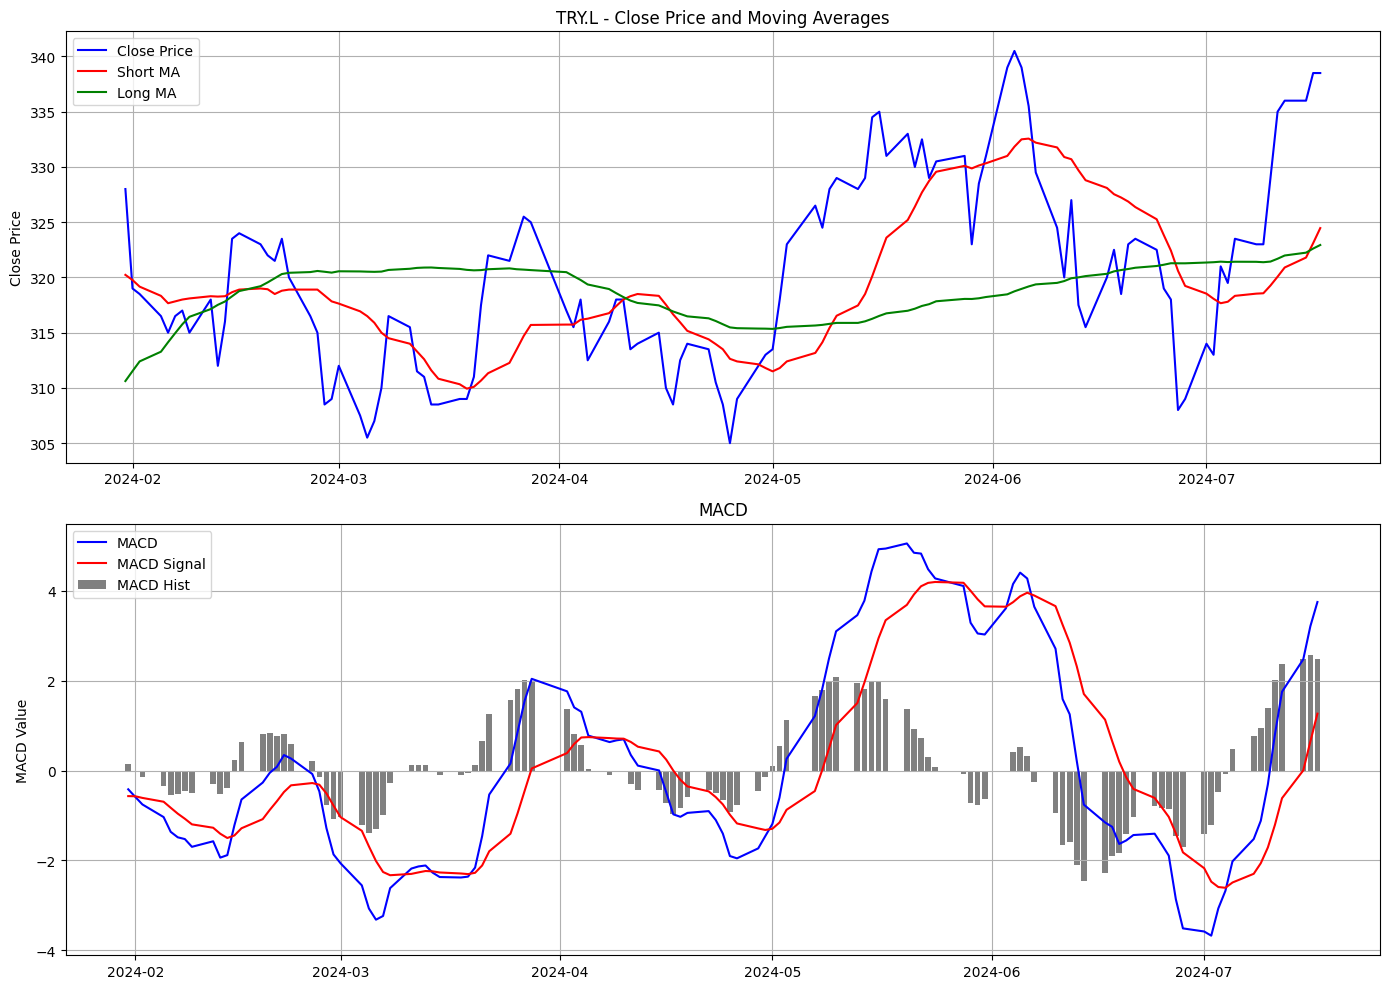

Ticker:                   TRY.L
Company:                  TR PROPERTY INVESTMENT TRUST PL
Sector:                   N/A
Industry:                 N/A
Market Cap:               £1,068,235,136
Shares Outstanding:       N/A
52-Week High:             361.33
52-Week Low:              252.95
PE Ratio (TTM):           5.429193
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A


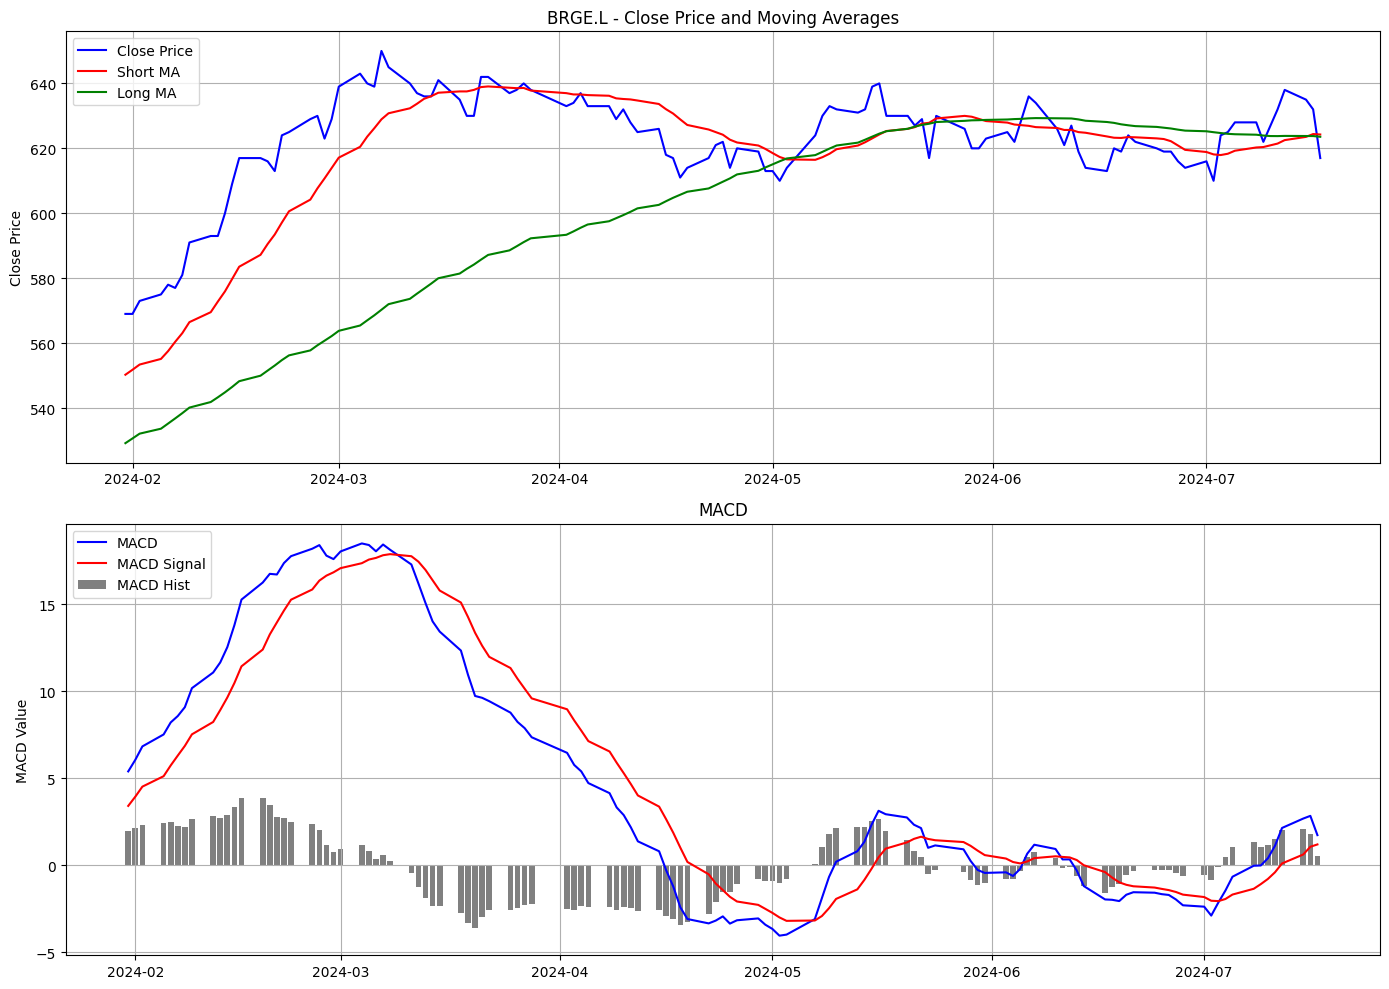

Ticker:                   BRGE.L
Company:                  BLACKROCK GREATER EUROPE INVEST
Sector:                   N/A
Industry:                 N/A
Market Cap:               £603,929,408
Shares Outstanding:       N/A
52-Week High:             671.09
52-Week Low:              457.5
PE Ratio (TTM):           5.2699046
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A


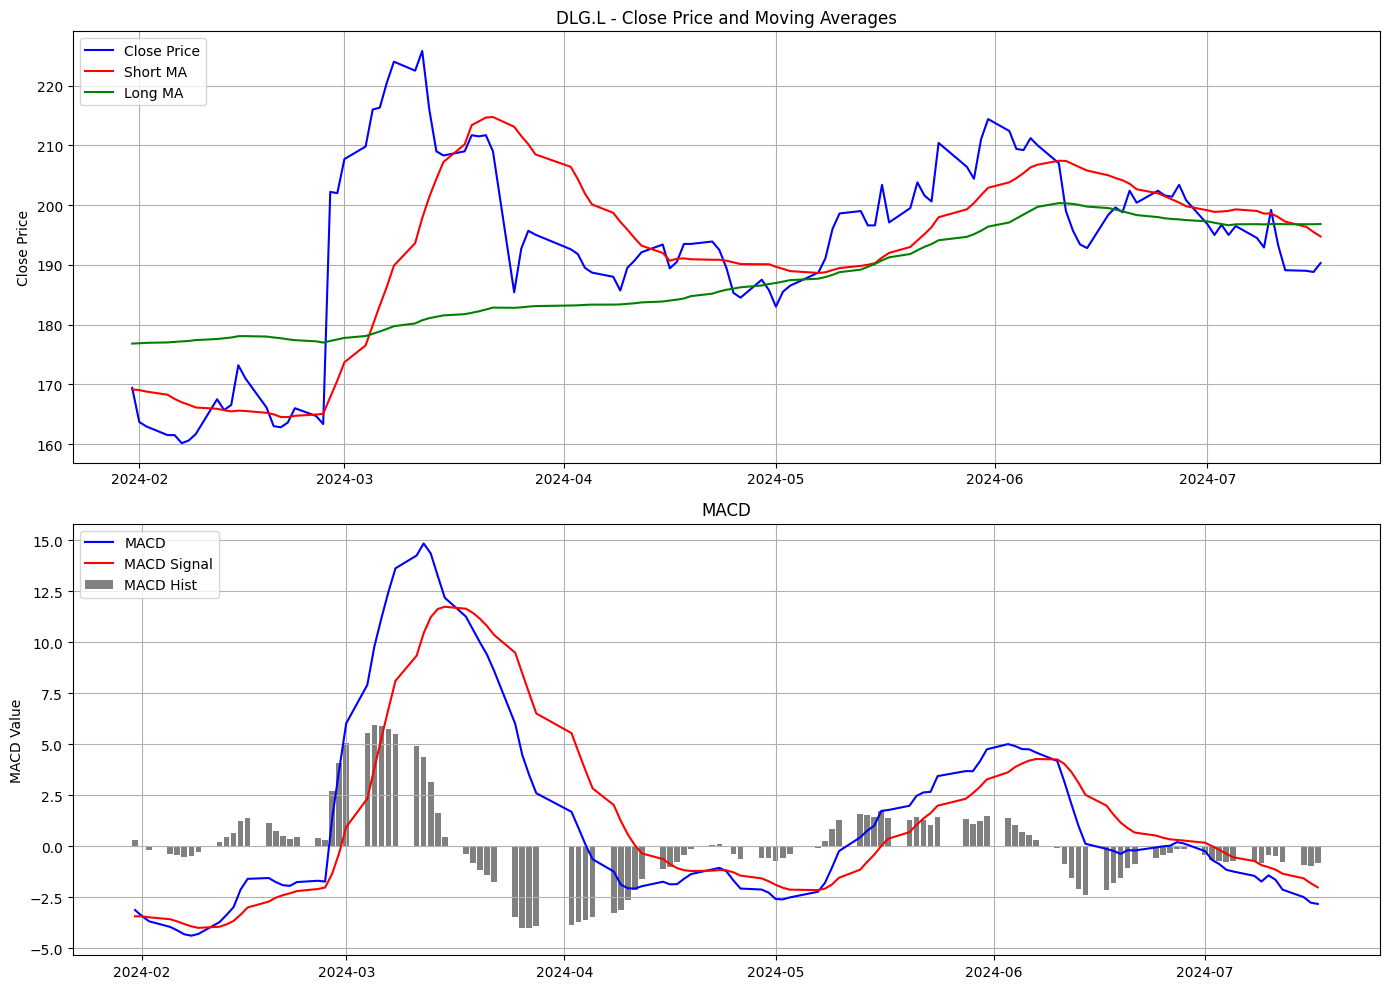

Ticker:                   DLG.L
Company:                  DIRECT LINE INSURANCE GROUP PLC
Sector:                   Financial Services
Industry:                 Insurance - Property & Casualty
Market Cap:               £2,444,762,880
Shares Outstanding:       1,297,699,968
52-Week High:             240.1
52-Week Low:              145.65
PE Ratio (TTM):           11.7745
EPS (TTM):                0.16
Dividend Yield:           0.0419
Payout Ratio:             0.0
Revenue (TTM):            £3,270,599,936
Gross Profit (TTM):       N/A
Net Income (TTM):         £206,300,000
Total Debt:               £454,200,000
Operating Cash Flow (TTM): £404,900,000
Free Cash Flow (TTM):     £-199,300,000

Description:              Direct Line Insurance Group plc engages in the provision of general insurance products and services in the United Kingdom. The company operates through Motor, Home, Rescue and Other Personal Lines, and Commercial segments. It offers motor, home, van, landlord, rescue, pet, tra

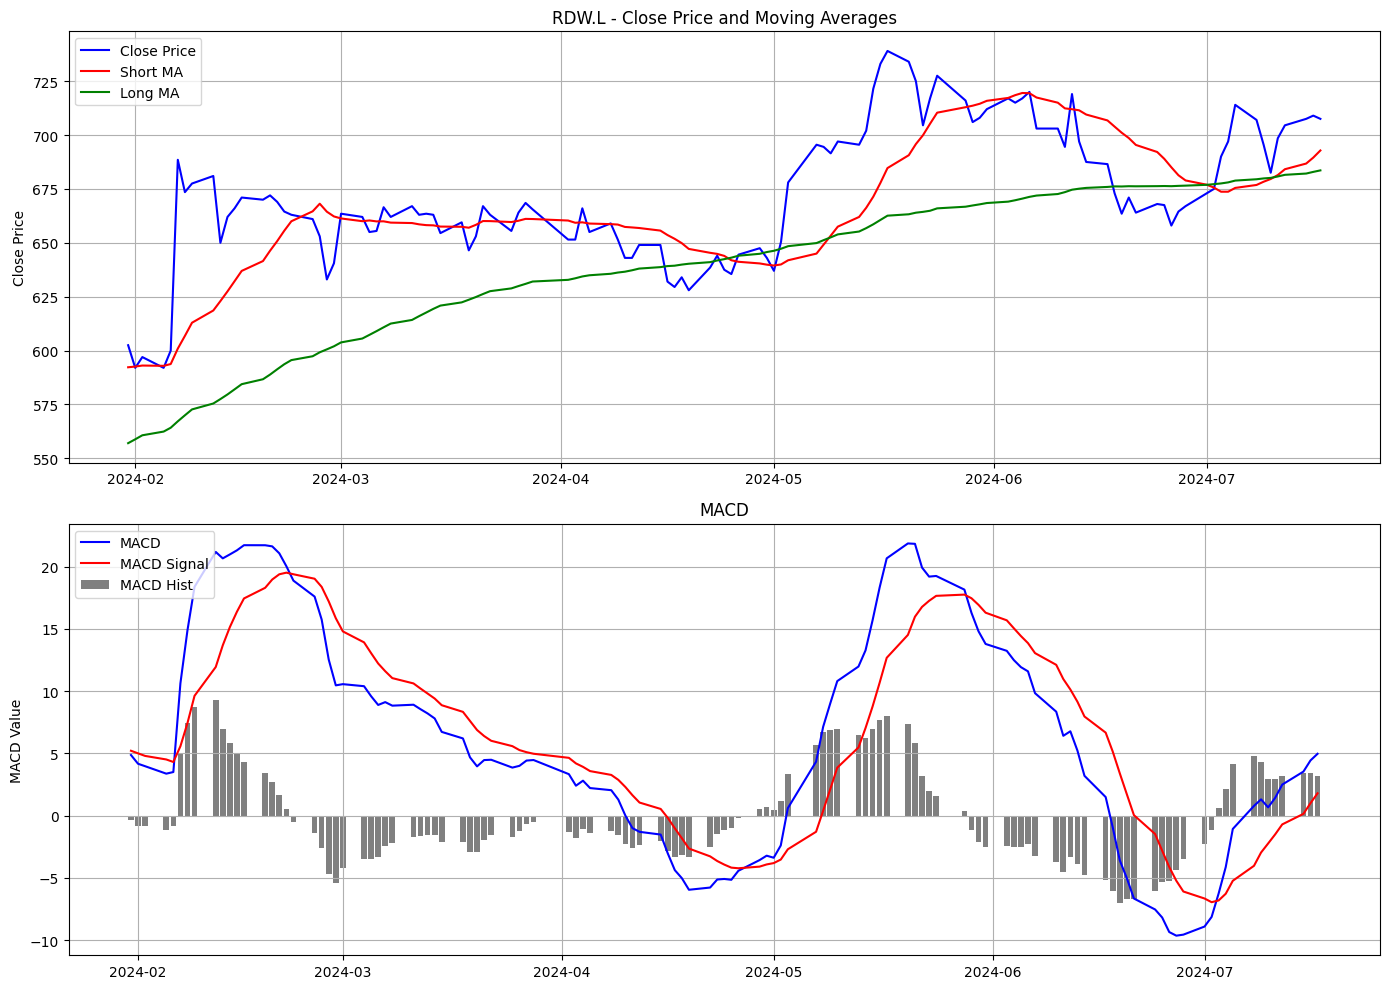

Ticker:                   RDW.L
Company:                  REDROW PLC ORD 10.5P
Sector:                   Consumer Cyclical
Industry:                 Residential Construction
Market Cap:               £2,315,389,952
Shares Outstanding:       330,769,984
52-Week High:             750.0
52-Week Low:              434.6
PE Ratio (TTM):           10.9375
EPS (TTM):                0.64
Dividend Yield:           0.0352
Payout Ratio:             0.4673
Revenue (TTM):            £1,852,000,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £208,000,000
Total Debt:               £0
Operating Cash Flow (TTM): £111,000,000
Free Cash Flow (TTM):     £91,875,000

Description:              Redrow plc focuses on housebuilding activities in the United Kingdom. It is involved in acquires, develops, and resells land; develops and sells residential housing properties; and business park maintenance services. Redrow plc was founded in 1974 and is based in Flintshire, the United Kingdom.


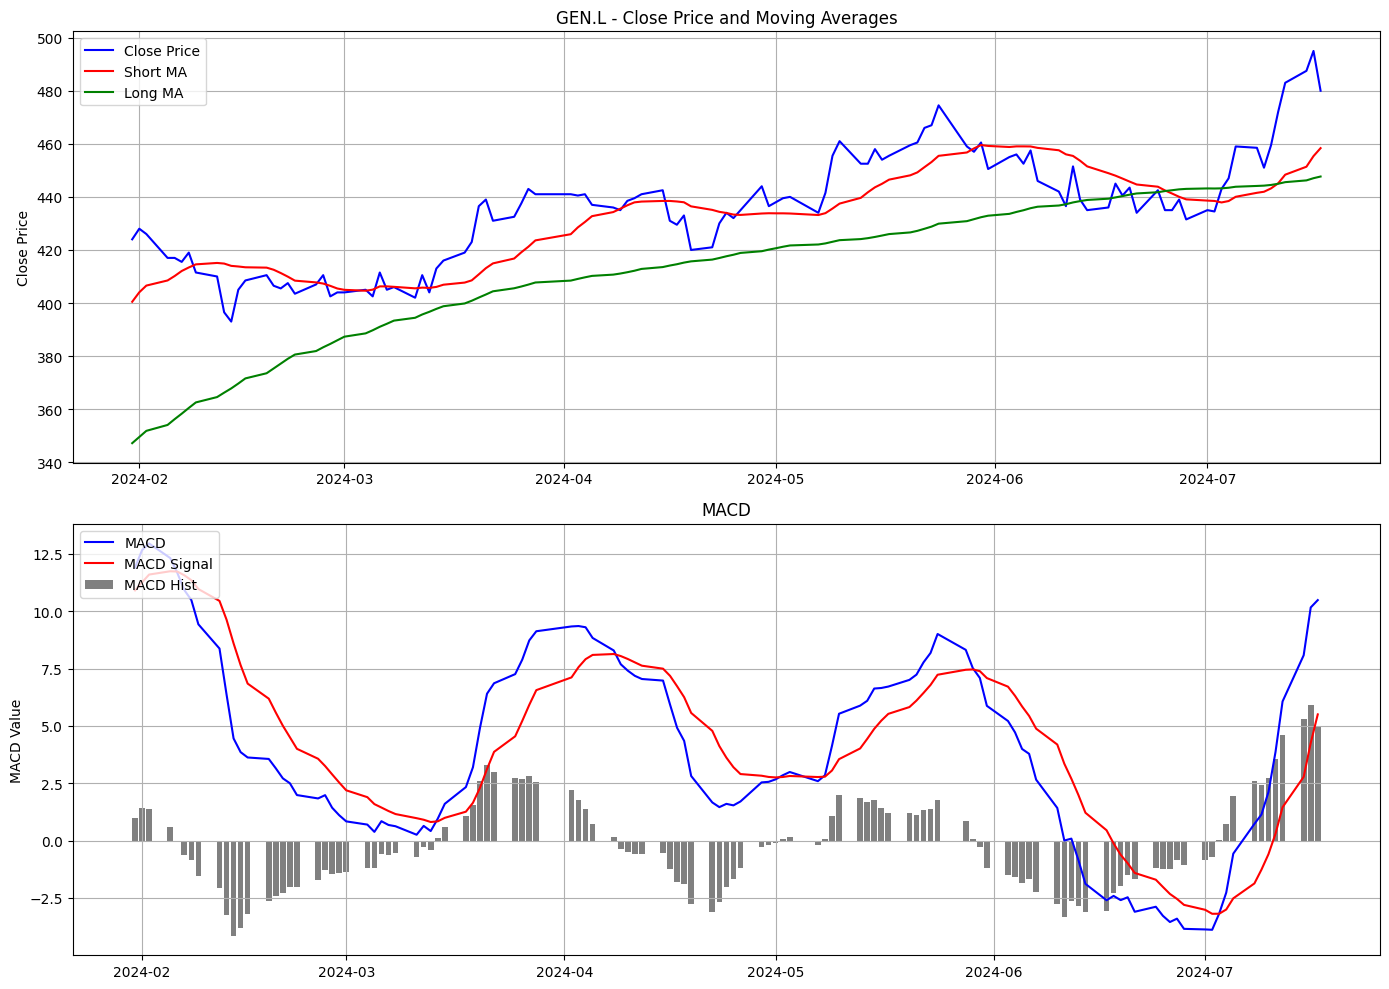

Ticker:                   GEN.L
Company:                  GENUIT GROUP PLC ORD GBP0.001
Sector:                   Industrials
Industry:                 Building Products & Equipment
Market Cap:               £1,218,441,344
Shares Outstanding:       249,170,000
52-Week High:             499.5
52-Week Low:              254.0
PE Ratio (TTM):           32.6
EPS (TTM):                0.15
Dividend Yield:           0.0255
Payout Ratio:             0.79870003
Revenue (TTM):            £586,499,968
Gross Profit (TTM):       N/A
Net Income (TTM):         £38,500,000
Total Debt:               £166,300,000
Operating Cash Flow (TTM): £97,600,000
Free Cash Flow (TTM):     £57,650,000

Description:              Genuit Group plc develops, manufactures, and sells water, climate, and ventilation management solutions in the United Kingdom, rest of the Europe, and internationally. The company operates through three segments: Sustainable Building Solutions, Water Management Solutions, and Climate Manageme

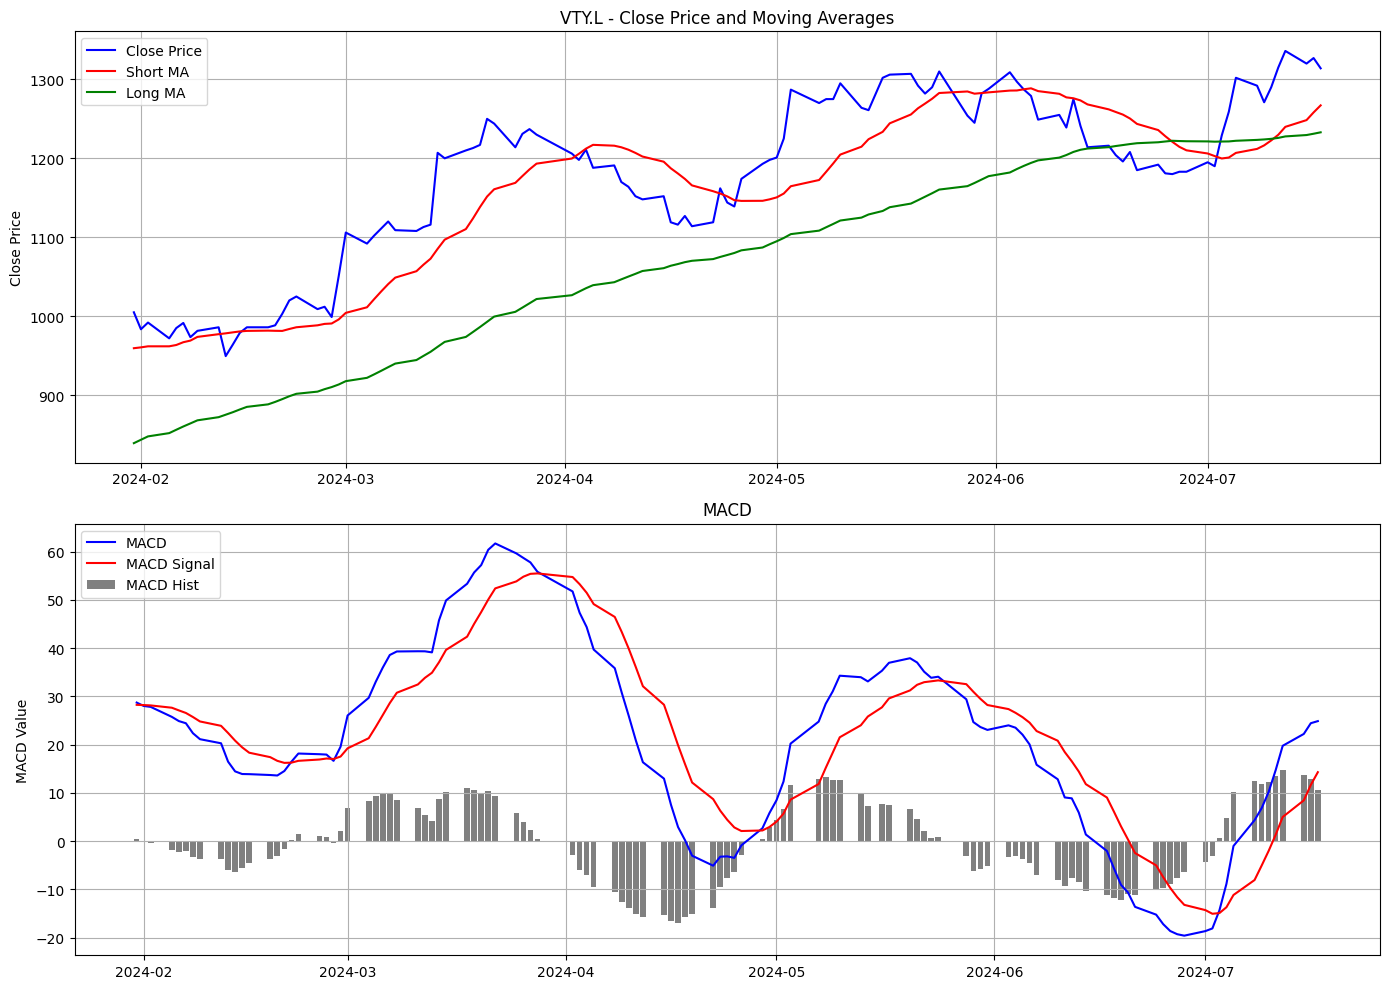

Ticker:                   VTY.L
Company:                  VISTRY GROUP PLC ORD 50P
Sector:                   Consumer Cyclical
Industry:                 Residential Construction
Market Cap:               £4,419,728,384
Shares Outstanding:       336,536,992
52-Week High:             1383.0
52-Week Low:              668.0
PE Ratio (TTM):           20.515625
EPS (TTM):                0.64
Dividend Yield:           N/A
Payout Ratio:             0.50240004
Revenue (TTM):            £3,564,199,936
Gross Profit (TTM):       N/A
Net Income (TTM):         £223,400,000
Total Debt:               £605,400,000
Operating Cash Flow (TTM): £-72,100,000
Free Cash Flow (TTM):     £-24,162,500

Description:              Vistry Group PLC, together with its subsidiaries, provides housing solutions in the United Kingdom. It offers o single family housing model. The company was formerly known as Bovis Homes Group PLC and changed its name to Vistry Group PLC in January 2020. Vistry Group PLC was founded in 18

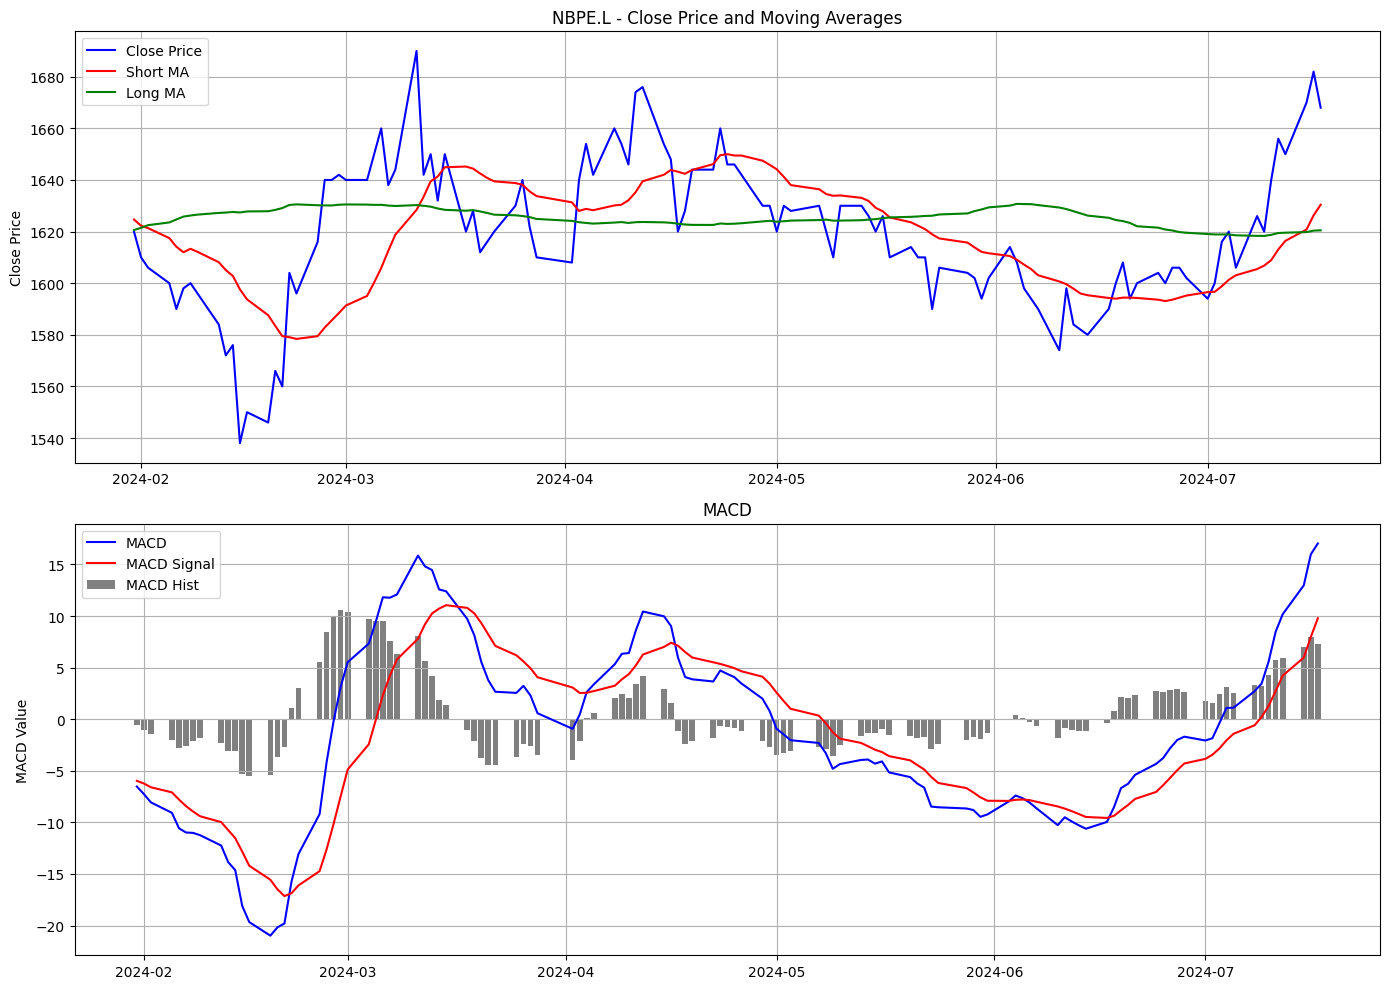

Ticker:                   NBPE.L
Company:                  NB PRIVATE EQUITY PARTNERS LIMI
Sector:                   N/A
Industry:                 N/A
Market Cap:               £775,416,064
Shares Outstanding:       N/A
52-Week High:             2180.647
52-Week Low:              1438.94
PE Ratio (TTM):           37.259083
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A


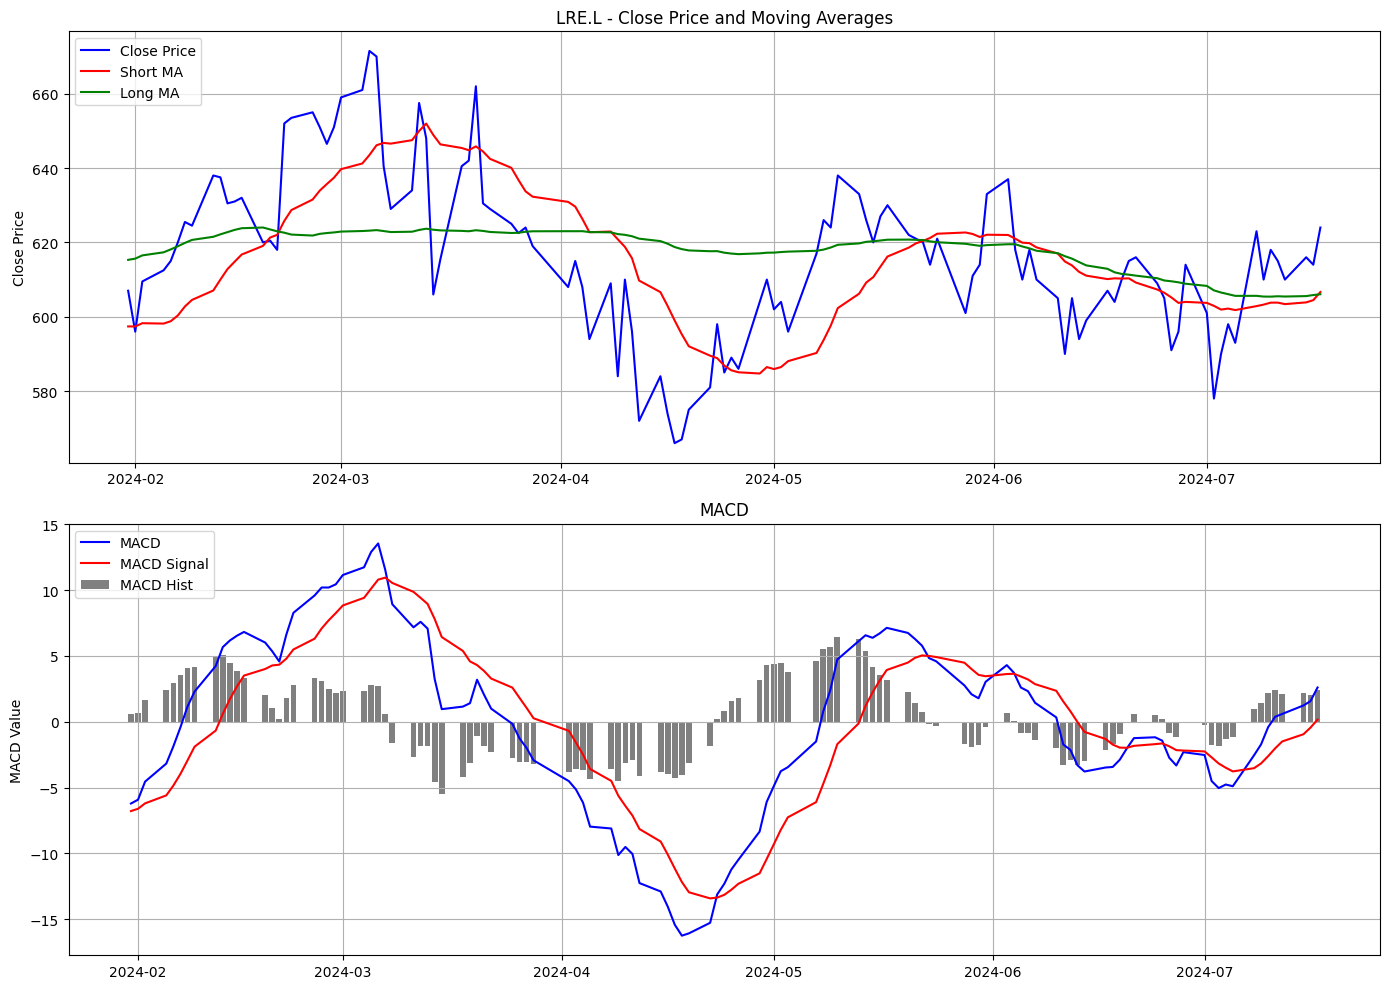

Ticker:                   LRE.L
Company:                  LANCASHIRE HOLDINGS LIMITED COM
Sector:                   Financial Services
Industry:                 Insurance - Specialty
Market Cap:               £1,465,721,216
Shares Outstanding:       239,038,000
52-Week High:             690.0
52-Week Low:              527.5
PE Ratio (TTM):           6.0710397
EPS (TTM):                1.01
Dividend Yield:           0.025799999
Payout Ratio:             0.113299996
Revenue (TTM):            £1,204,000,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £321,500,000
Total Debt:               £471,300,000
Operating Cash Flow (TTM): £441,900,000
Free Cash Flow (TTM):     £371,262,496

Description:              Lancashire Holdings Limited, together with its subsidiaries, provides specialty insurance and reinsurance products in London, Bermuda, Australia, and the United States. The company operates through two segments, Reinsurance and Insurance. It offers property direct and faculta

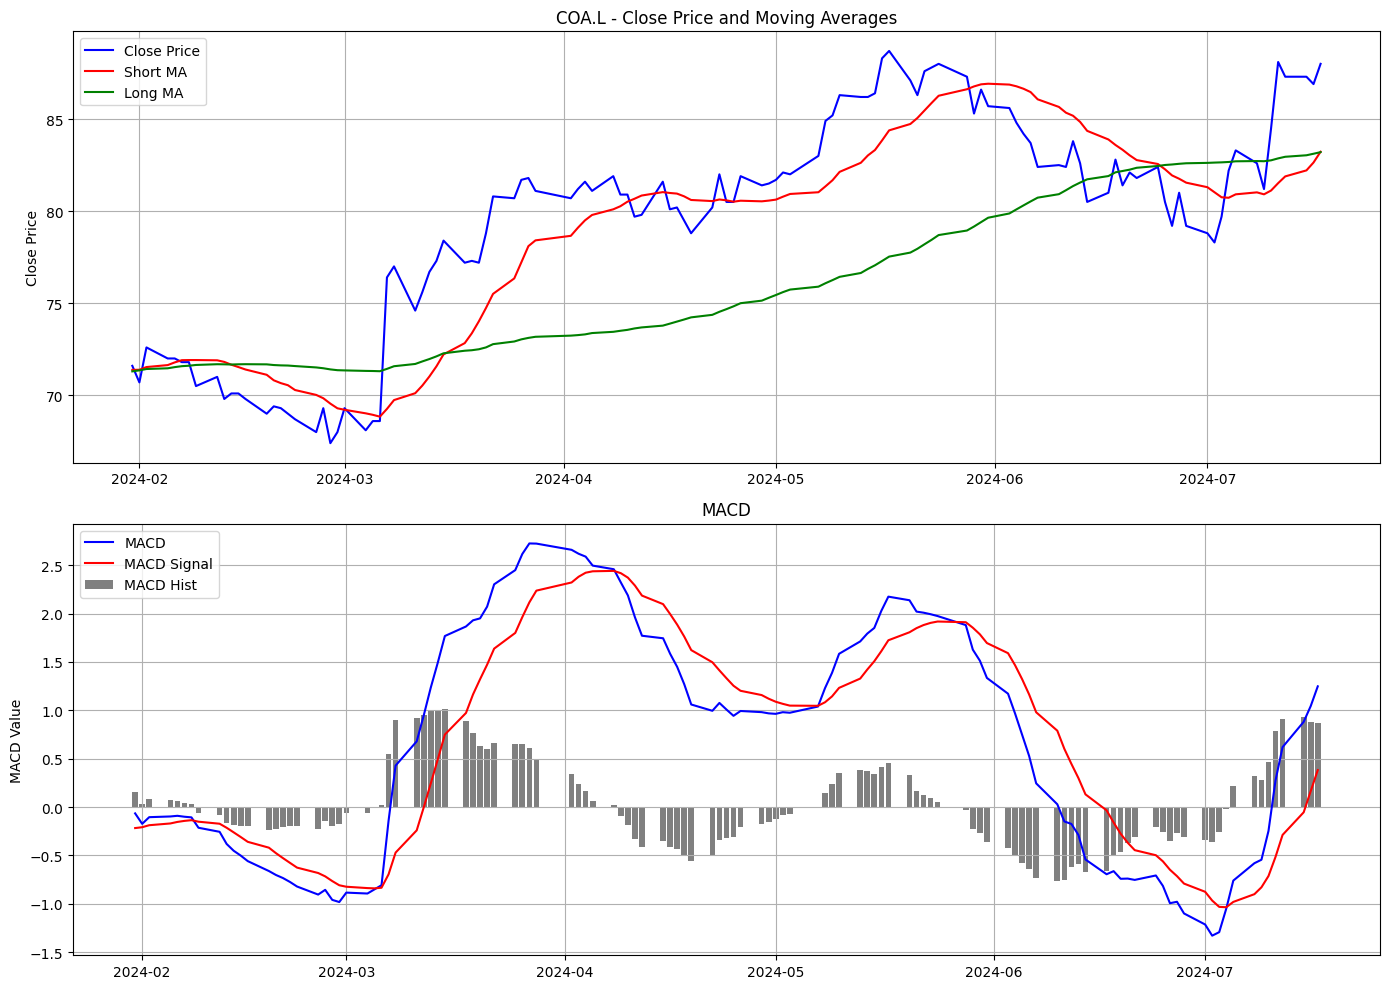

Ticker:                   COA.L
Company:                  COATS GROUP PLC ORD 5P
Sector:                   Consumer Cyclical
Industry:                 Textile Manufacturing
Market Cap:               £1,389,545,344
Shares Outstanding:       1,591,689,984
52-Week High:             89.6
52-Week Low:              64.3
PE Ratio (TTM):           21.825
EPS (TTM):                0.04
Dividend Yield:           0.025
Payout Ratio:             0.4951
Revenue (TTM):            £1,394,200,064
Gross Profit (TTM):       N/A
Net Income (TTM):         £83,200,000
Total Debt:               £603,299,968
Operating Cash Flow (TTM): £123,900,000
Free Cash Flow (TTM):     £196,350,000

Description:              Coats Group plc, together with its subsidiaries, manufactures and supplies industrial sewing threads worldwide. The company provides threads, yarns, zips, trims, composites, and fabrics for use in apparel, such as children's wear, denims, intimate and underwear, ladieswear, leather wear, menswear, sp

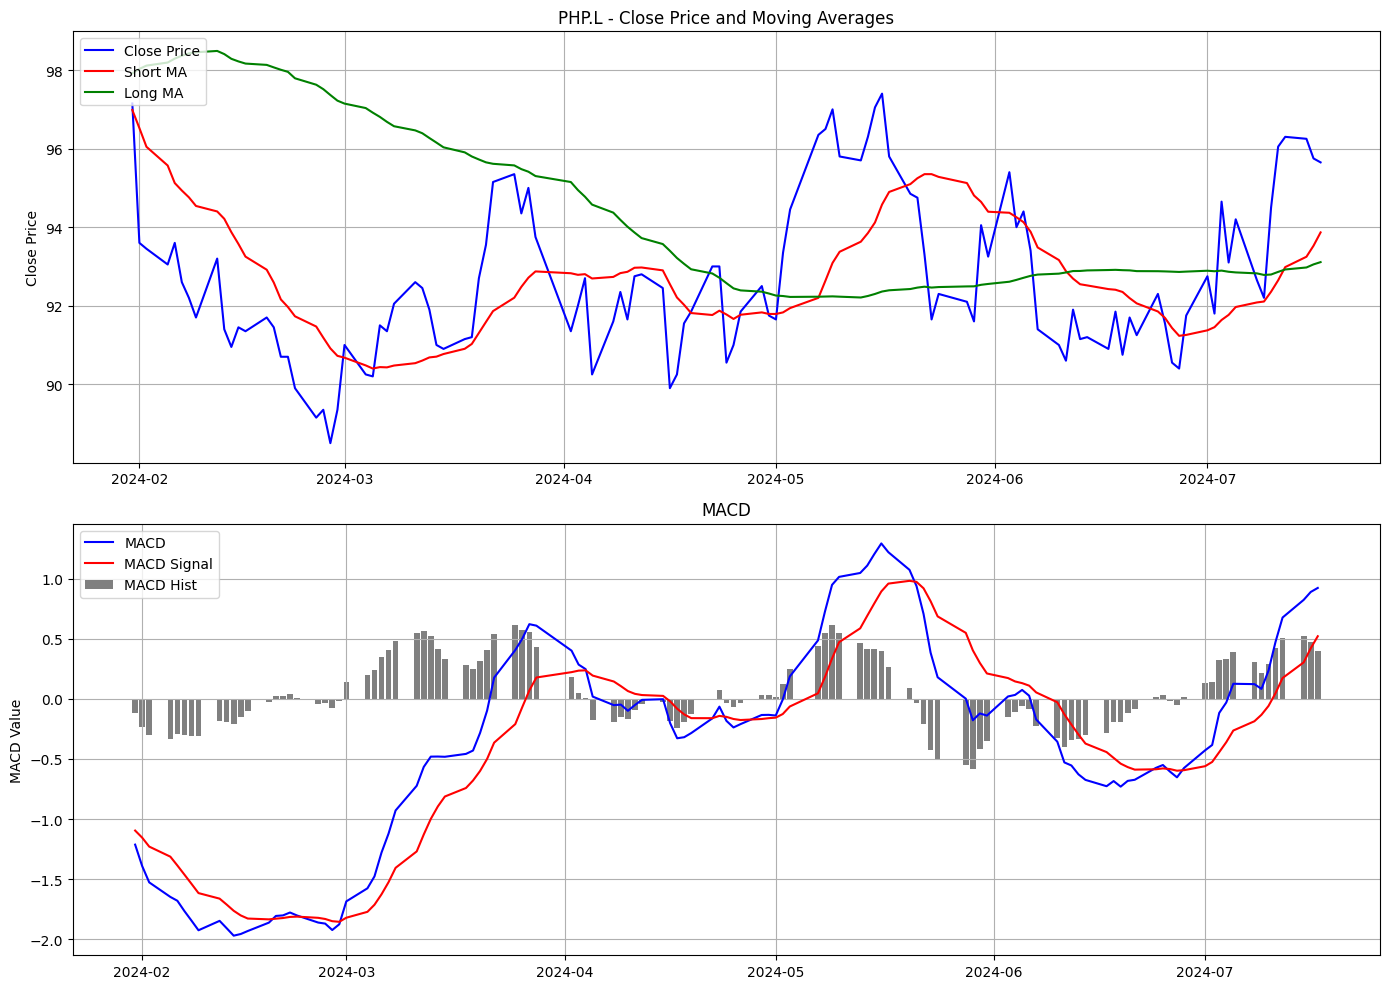

Ticker:                   PHP.L
Company:                  PRIMARY HEALTH PROPERTIES PLC O
Sector:                   Real Estate
Industry:                 REIT - Healthcare Facilities
Market Cap:               £1,262,838,144
Shares Outstanding:       1,335,629,952
52-Week High:             109.0
52-Week Low:              84.2
PE Ratio (TTM):           47.275
EPS (TTM):                0.02
Dividend Yield:           0.0718
Payout Ratio:             3.35
Revenue (TTM):            £169,800,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £27,300,000
Total Debt:               £1,332,999,936
Operating Cash Flow (TTM): £133,600,000
Free Cash Flow (TTM):     £49,575,000

Description:              Primary Health Properties (PHP) is the leading investor in modern healthcare properties in the UK & Ireland. PHP is a UK based Real Estate Investment Trust (REIT) with a clear objective to create progressive returns to shareholders through a combination of earnings growth and capital appreci

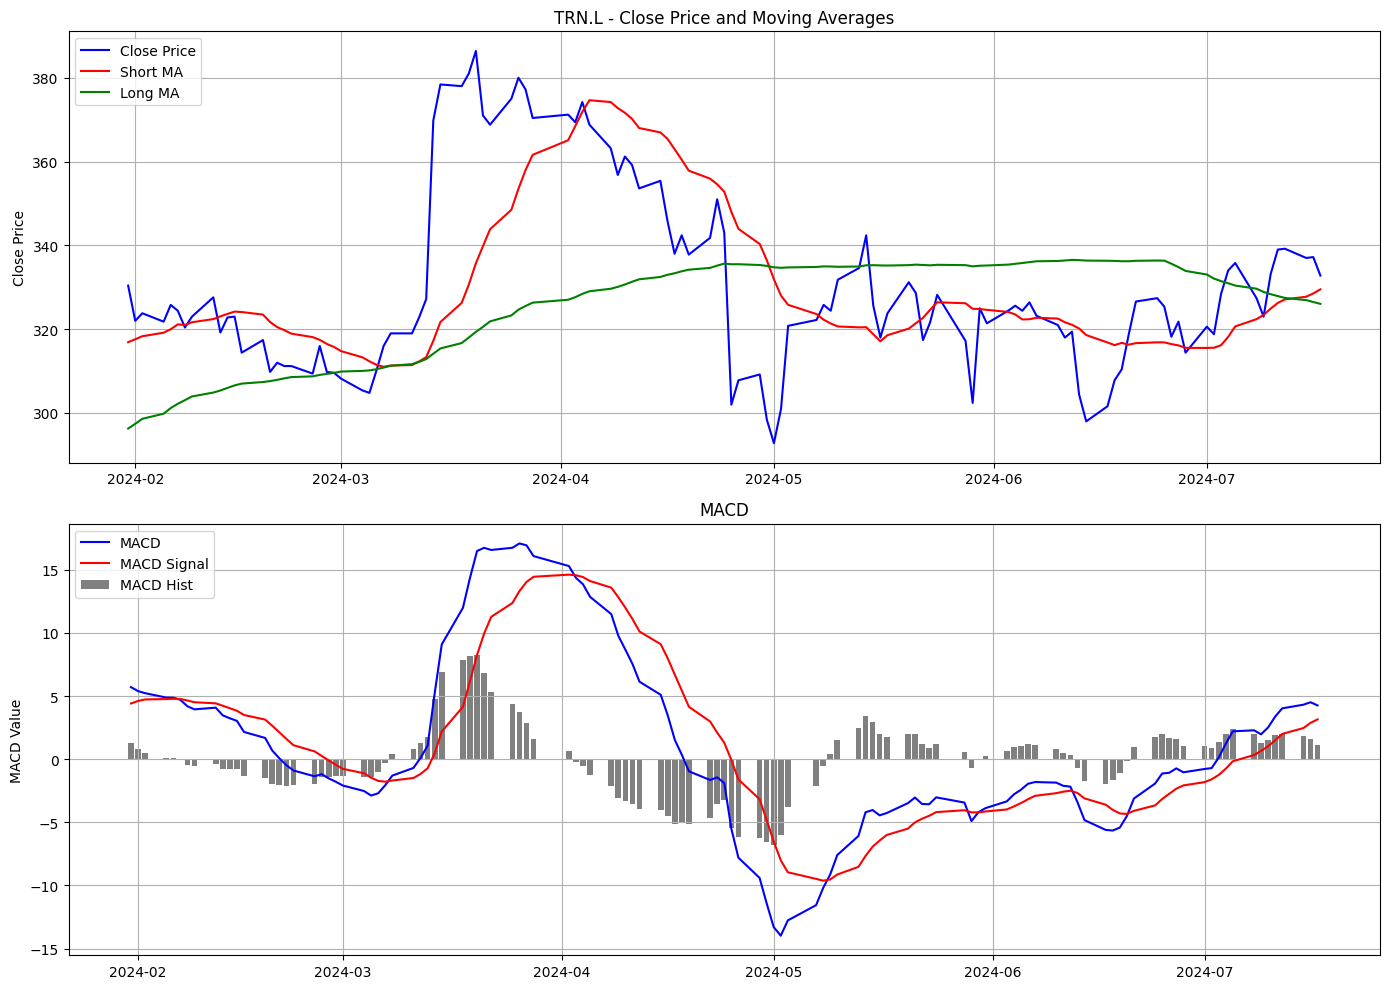

Ticker:                   TRN.L
Company:                  TRAINLINE PLC ORD 1P
Sector:                   Consumer Cyclical
Industry:                 Travel Services
Market Cap:               £1,502,493,952
Shares Outstanding:       449,060,000
52-Week High:             393.8
52-Week Low:              216.4
PE Ratio (TTM):           47.784225
EPS (TTM):                0.07
Dividend Yield:           N/A
Payout Ratio:             0.0
Revenue (TTM):            £396,718,016
Gross Profit (TTM):       N/A
Net Income (TTM):         £33,986,000
Total Debt:               £153,112,992
Operating Cash Flow (TTM): £121,729,000
Free Cash Flow (TTM):     £68,501,504

Description:              Trainline Plc engages in the operation of an independent rail and coach travel platform that sells rail and coach tickets the United Kingdom and internationally. It operates through three segments: UK Consumer, International Consumer, and Trainline Solutions. The UK Consumer segment provides travel apps and websi

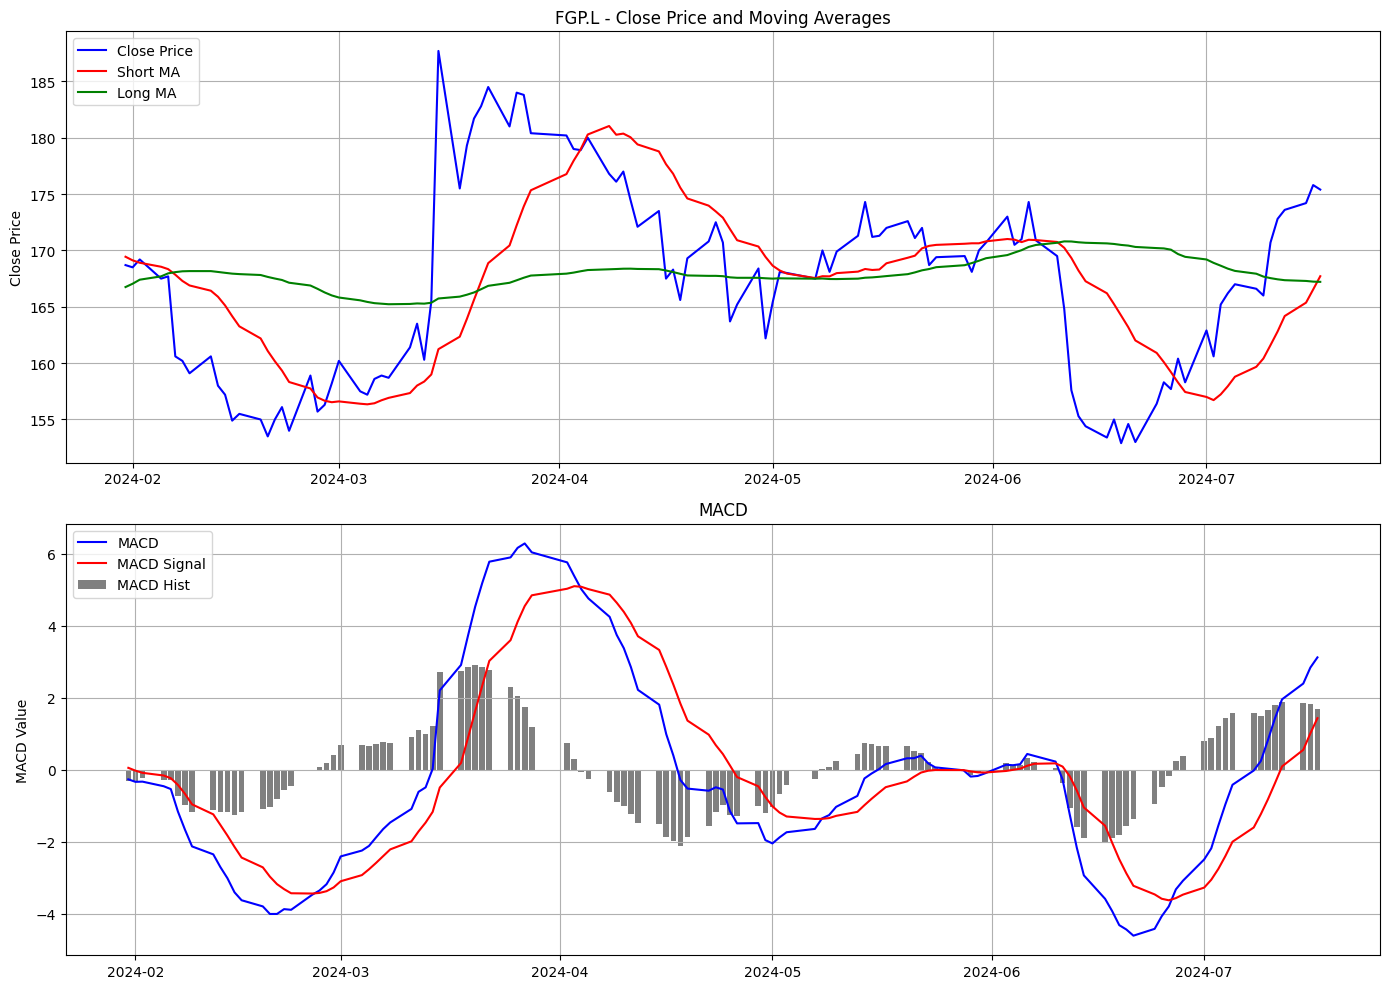

Ticker:                   FGP.L
Company:                  FIRSTGROUP PLC ORD 5P
Sector:                   Industrials
Industry:                 Railroads
Market Cap:               £1,034,297,536
Shares Outstanding:       603,608,000
52-Week High:             189.0
52-Week Low:              135.0
PE Ratio (TTM):           N/A
EPS (TTM):                -0.02
Dividend Yield:           0.0321
Payout Ratio:             0.1942
Revenue (TTM):            £4,715,100,160
Gross Profit (TTM):       N/A
Net Income (TTM):         £-10,200,000
Total Debt:               £1,645,299,968
Operating Cash Flow (TTM): £543,299,968
Free Cash Flow (TTM):     £445,362,496

Description:              FirstGroup plc provides public transport services in the United Kingdom. The company operates through First Bus and First Rail segments. The First Bus segment offers local bus services with a fleet of approximately 4,800 buses in the United Kingdom. The First Rail segment operates a passenger rail network that provid

In [56]:
# Function to print basic financial data
def print_financial_data(ticker, stock_data):
    stock = yf.Ticker(ticker)
    info = stock.info

    def format_value(value, currency=False):
        if isinstance(value, (int, float)):
            formatted_value = f"{value:,}"
            if currency:
                formatted_value = f"£{formatted_value}"
            return formatted_value
        return value

    market_cap = format_value(info.get('marketCap', 'N/A'), currency=True)
    shares_outstanding = format_value(info.get('sharesOutstanding', 'N/A'))
    year_high = info.get('fiftyTwoWeekHigh', 'N/A')
    year_low = info.get('fiftyTwoWeekLow', 'N/A')
    pe_ratio = info.get('trailingPE', 'N/A')
    eps = info.get('trailingEps', 'N/A')
    dividend_yield = info.get('dividendYield', 'N/A')
    payout_ratio = info.get('payoutRatio', 'N/A')
    revenue = format_value(info.get('totalRevenue', 'N/A'), currency=True)
    gross_profit = format_value(info.get('grossProfits', 'N/A'), currency=True)
    net_income = format_value(info.get('netIncomeToCommon', 'N/A'), currency=True)
    total_debt = format_value(info.get('totalDebt', 'N/A'), currency=True)
    operating_cash_flow = format_value(info.get('operatingCashflow', 'N/A'), currency=True)
    free_cash_flow = format_value(info.get('freeCashflow', 'N/A'), currency=True)
    sector = info.get('sector', 'N/A')
    industry = info.get('industry', 'N/A')
    description = info.get('longBusinessSummary', 'N/A')

    print(f"{'Ticker:':<25} {ticker}")
    print(f"{'Company:':<25} {info.get('shortName', 'N/A')}")
    print(f"{'Sector:':<25} {sector}")
    print(f"{'Industry:':<25} {industry}")
    print(f"{'Market Cap:':<25} {market_cap}")
    print(f"{'Shares Outstanding:':<25} {shares_outstanding}")
    print(f"{'52-Week High:':<25} {year_high}")
    print(f"{'52-Week Low:':<25} {year_low}")
    print(f"{'PE Ratio (TTM):':<25} {pe_ratio}")
    print(f"{'EPS (TTM):':<25} {eps}")
    print(f"{'Dividend Yield:':<25} {dividend_yield}")
    print(f"{'Payout Ratio:':<25} {payout_ratio}")
    print(f"{'Revenue (TTM):':<25} {revenue}")
    print(f"{'Gross Profit (TTM):':<25} {gross_profit}")
    print(f"{'Net Income (TTM):':<25} {net_income}")
    print(f"{'Total Debt:':<25} {total_debt}")
    print(f"{'Operating Cash Flow (TTM):':<25} {operating_cash_flow}")
    print(f"{'Free Cash Flow (TTM):':<25} {free_cash_flow}")
    print(f"\n{'Description:':<25} {description}")  # Print the full description

# Function to plot MA and MACD indicators
def plot_ma_macd(data, symbol):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    # Plot Close Price and Moving Averages
    ax1.plot(data.index, data['Close'], label='Close Price', color='blue')
    ax1.plot(data.index, data['Short_MA'], label='Short MA', color='red')
    ax1.plot(data.index, data['Long_MA'], label='Long MA', color='green')
    ax1.set_title(f'{symbol} - Close Price and Moving Averages')
    ax1.set_ylabel('Close Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Plot MACD
    ax2.plot(data.index, data['MACD'], label='MACD', color='blue')
    ax2.plot(data.index, data['MACD_Signal'], label='MACD Signal', color='red')
    ax2.bar(data.index, data['MACD_Hist'], label='MACD Hist', color='grey')
    ax2.set_title('MACD')
    ax2.set_ylabel('MACD Value')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

print("The following stocks have met the specified criteria. A plot is displayed showing the stock price and its relationship to the associated indicators. Additionally, detailed financial and company information is provided for each stock.\n")

# Iterate through all tickers that meet the criteria to plot graphs and print financial data
for stock_data in results:
    symbol = stock_data["Symbol"]
    data = stock_data["Data"]
    plot_ma_macd(data, symbol)
    print_financial_data(symbol, stock_data)